In [3]:
from astropy import units as u
from astropy.cosmology import Planck18_arXiv_v2, z_at_value
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.interpolate import interp1d

# Matplotlib settings
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
matplotlib.rcParams['xtick.labelsize'] = 24.0
matplotlib.rcParams['ytick.labelsize'] = 24.0
matplotlib.rcParams['axes.titlesize'] = 27.0
matplotlib.rcParams['axes.labelsize'] = 27.0
matplotlib.rcParams['legend.fontsize'] = 24.0
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
matplotlib.rcParams['font.serif'] = ['Computer Modern', 'Times New Roman']
matplotlib.rcParams['font.family'] = ['serif', 'STIXGeneral']
matplotlib.rcParams['legend.frameon'] = True
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

# Local imports
from cocteau import matrix, observations
from cocteau import observational_utils as utils

import sys
sys.path.append('/Users/r349989/Documents/kilonovae/projects/kilonova_detectability/')
from plot_contours import plot_contours as pc


data_dir = '/Users/r349989/Documents/kilonovae/data/converted_lightcurves/'

In [2]:
# Read in the data
filter_data = pd.read_csv('/Users/r349989/Documents/kilonovae/projects/kilonova_detectability/data/combined_instr_detectability.csv')
filter_data = filter_data[filter_data['Instrument'] != 'Dorado'].reset_index(drop=True)
filter_data


,Instrument,z5,z50,z95,z50_t6,z50_t12,z50_t18,z50_t24,z50_t48,z50_t72,z50_t96,z50_t384
0,BlackGEM,0.240,0.072,0.0270,0.064,0.0690,0.0680,0.0650,0.0460,0.0370,0.0300,0.0044
1,DDOTI,0.073,0.023,0.0083,0.021,0.0210,0.0190,0.0180,0.0092,0.0026,0.0012,0.0000
2,DECam,0.180,0.058,0.0230,0.047,0.0560,0.0550,0.0510,0.0370,0.0220,0.0180,0.0022
3,GOTO,0.097,0.029,0.0097,0.028,0.0270,0.0220,0.0190,0.0068,0.0015,0.0000,0.0000
4,LSST,0.480,0.150,0.0480,0.150,0.1300,0.1200,0.1100,0.0610,0.0370,0.0300,0.0039
5,MeerLICHT,0.080,0.025,0.0100,0.022,0.0240,0.0230,0.0220,0.0180,0.0150,0.0096,0.0021
6,PRIME,0.067,0.023,0.0100,0.020,0.0220,0.0230,0.0220,0.0190,0.0170,0.0150,0.0022
7,Roman,0.970,0.290,0.1100,0.260,0.2800,0.2900,0.2800,0.2600,0.2300,0.2000,0.0600
8,Swift,0.061,0.015,0.0019,0.013,0.0080,0.0038,0.0020,0.0000,0.0000,0.0000,0.0000
9,ULTRASAT,0.100,0.022,0.0022,0.018,0.0086,0.0041,0.0014,0.0000,0.0000,0.0000,0.0000


In [422]:
filter_data.shape

(13, 12)

In [4]:
# Set up plot aesthetics
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap


instr_params = {
    'BlackGEM': {'label': 'BlackGEM', 'marker': '^', 'FoV': 8.1, 'exp': 300},
    'DDOTI': {'label': 'DDOTI', 'marker': 'D', 'FoV': 69, 'exp': 7200},
    'DECam': {'label': 'DECam', 'marker': 'X', 'FoV': 2.2, 'exp': 90},
    #'Dorado': {'label': 'Dorado', 'marker': '<', 'FoV': 50.6, 'exp': 600},
    'GOTO': {'label': 'GOTO', 'marker': '>', 'FoV': 40, 'exp': 360},
    'LSST': {'label': 'LSST', 'marker': 'd', 'FoV': 9.6, 'exp': 30},
    'MeerLICHT': {'label': 'MeerLICHT', 'marker': 'h', 'FoV': 2.7, 'exp': 60},
    'PRIME': {'label': 'PRIME', 'marker': 'o', 'FoV': 1.56, 'exp': 100},
    'Roman': {'label': 'Roman', 'marker': '*', 'FoV': 0.28, 'exp': 67},
    'Swift': {'label': 'Swift', 'marker': 'v', 'FoV': 0.08, 'exp': 80},
    'ULTRASAT': {'label': 'ULTRASAT', 'marker':'8', 'FoV': 200, 'exp': 900},
    'VISTA': {'label': 'VISTA', 'marker':'p', 'FoV': 1.6, 'exp': 360},
    'WINTER': {'label': 'WINTER', 'marker':'P', 'FoV': 1.0, 'exp': 360},
    'ZTF': {'label': 'ZTF', 'marker': 's', 'FoV': 47, 'exp': 30},
}

cmap = truncate_colormap(matplotlib.cm.inferno, minval=0.2)
color_norm = matplotlib.colors.Normalize(vmin=0, vmax=len(instr_params)-1)

instr_color_order = ['Roman', 'LSST', 'DECam', 'PRIME',
    'BlackGEM', 'VISTA', 'ULTRASAT', 'WINTER', 'GOTO', 
    'ZTF', 'MeerLICHT', 'Swift', 'DDOTI']#,'Dorado']
for idx, instr in enumerate(instr_color_order):
    instr_params[instr]['color'] = cmap(color_norm(idx))

# Set timestamps
time_data = {
    6:   {'label': '$t=6$ hr',   'col': 'z50_t6'},
    12:  {'label': '$t=12$ hr', 'col': 'z50_t12'},
    18:  {'label': '$t=18$ hr', 'col': 'z50_t18'},
    24:  {'label': '$t=1$ d',   'col': 'z50_t24'},
    48:  {'label': '$t=2$ d',   'col': 'z50_t48'},
    72:  {'label': '$t=3$ d',   'col': 'z50_t72'},
    96:  {'label': '$t=4$ d',   'col': 'z50_t96'},
    384: {'label': '$t=16$ d',   'col': 'z50_t384'},
}

    


In [5]:
def make_bar_chart(filter_data, order='alpha', log=False, 
    ymax=0.3, fade=False, gwranges=None, 
    arrowbottom=0.26, arrowtop=0.29, time=None):
    
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Check that given time is valid
    if time is not None:
        assert time in time_data.keys()
        time_col = time_data[time]['col']
        ax.set_title(time_data[time]['label'])

    x = np.arange(len(filter_data))
    for idx, band in filter_data.iterrows():
        color = instr_params[band['Instrument']]['color']
        if fade:
            ax.bar(x[idx], band['z95'], color=color, edgecolor='k')
            ax.bar(x[idx], band['z50'], alpha=0.6, color=color, edgecolor='k')
            ax.bar(x[idx], band['z5'], alpha=0.2, color=color, edgecolor='k')

        elif time is not None:
            ax.bar(x[idx], band[time_col], color=color, edgecolor='k')
            
        else:
            ax.bar(x[idx], band['z50'], color=color, edgecolor='k')
            
    # For legend
    if fade:
        ax.bar(-5, 0.1, color='k', alpha=0.2, 
            edgecolor='k', label=r'$z_{5\%}$')
        ax.bar(-5, 0.1, color='k', alpha=0.6, 
            edgecolor='k', label=r'$z_{50\%}$')
        ax.bar(-5, 0.1, color='k', alpha=1.0, 
            edgecolor='k', label=r'$z_{95\%}$')
    else:
        ax.bar(-5, 0.1, color='k', edgecolor='k', label=r'$z_{50\%}$')
    

    # Set labels
    xlabels = filter_data['Instrument'].values
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=45, 
        ha='right', rotation_mode='anchor')
    
    xmin, xmax = ax.get_xlim()
    
    
    
        
    if log:        
        ax.set_yscale('log')
    ax.set_ylim(0.001, ymax)
    ymin, ymax = ax.get_ylim()
    
    # Second y axis for luminosity distance
    ax2 = ax.twinx()
    if log:
        dist_arr = [10, 25, 100, 400, 1600, 6400, 6400*4]
        u_dist = u.Mpc
        ax2.set_yscale('log')
        ax2.minorticks_off()
    else:
        if ymax > 0.5:
            dist_arr = [0.1, 1, 2, 3, 4, 5, 6, 7, 8]
            u_dist = u.Gpc
        else:
            dist_arr = [25, 500, 1000, 1500, 2000, 2500, 3000]
            u_dist = u.Mpc

    ax2.set_yticks([z_at_value(
        Planck18_arXiv_v2.luminosity_distance,
        dist * u_dist) for dist in dist_arr])
    ax2.set_yticklabels(dist_arr)
    ax2.set_ylim(ymin, ymax)
    if u_dist == u.Gpc:
        ax2.set_ylabel(r'Luminosity Distance $\left[\mathrm{Gpc}\right]$')
    elif u_dist == u.Mpc:
        ax2.set_ylabel(r'Luminosity Distance $\left[\mathrm{Mpc}\right]$')

    
        
    # Set factor to shift label by
    if log:
        label_shifter = lambda x: x * 1.2
    else:
        label_shifter = lambda x: x + (ymax/50)
    
    xpos = -1
    if gwranges == 'zhoriz':
        # Add typical GW horizon redshifts for 1.4+1.4 BNS
        at2017gfo = 0.0098
        aligo = 0.1
        voyager = 0.45
        #ax.set_xlim(xmin+2, xmax)
        ax.axhline(y=at2017gfo, color='magenta', ls='-.', label=r'AT\,2017gfo')
#         ax.annotate('AT 2017gfo', (xpos, label_shifter(at2017gfo)), 
#             xycoords='data', color='magenta', fontsize=25)
        ax.axhline(y=aligo, color='blue', ls='-.', zorder=-1, label='aLIGO')
#         ax.annotate('aLIGO', (xpos, label_shifter(aligo)), 
#             xycoords='data', color='blue', fontsize=25)
        ax.annotate('', xy=(xpos,arrowtop), xytext=(xpos,arrowbottom), 
            arrowprops=dict(facecolor='green', shrink=0.05, 
            edgecolor='green'))
        ax.annotate('3G Detectors', (xpos+0.2, arrowbottom), xycoords='data', 
            color='green', fontsize=25)
    #else:
    ax.set_xlim(xmin+5, xmax)

    
    ax.set_ylabel('Redshift')
    ax.legend(loc='upper left')
    
    
    #ax.grid(axis='y', ls='--')
    
    return ax
    
    

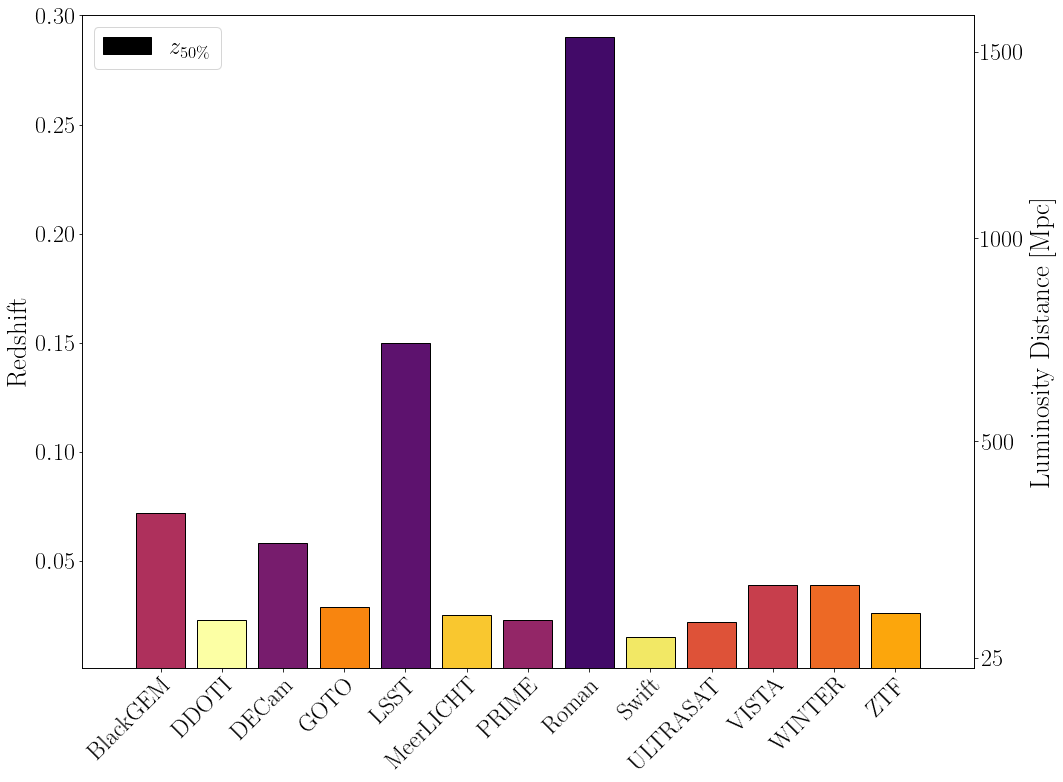

In [6]:
ax = make_bar_chart(filter_data)

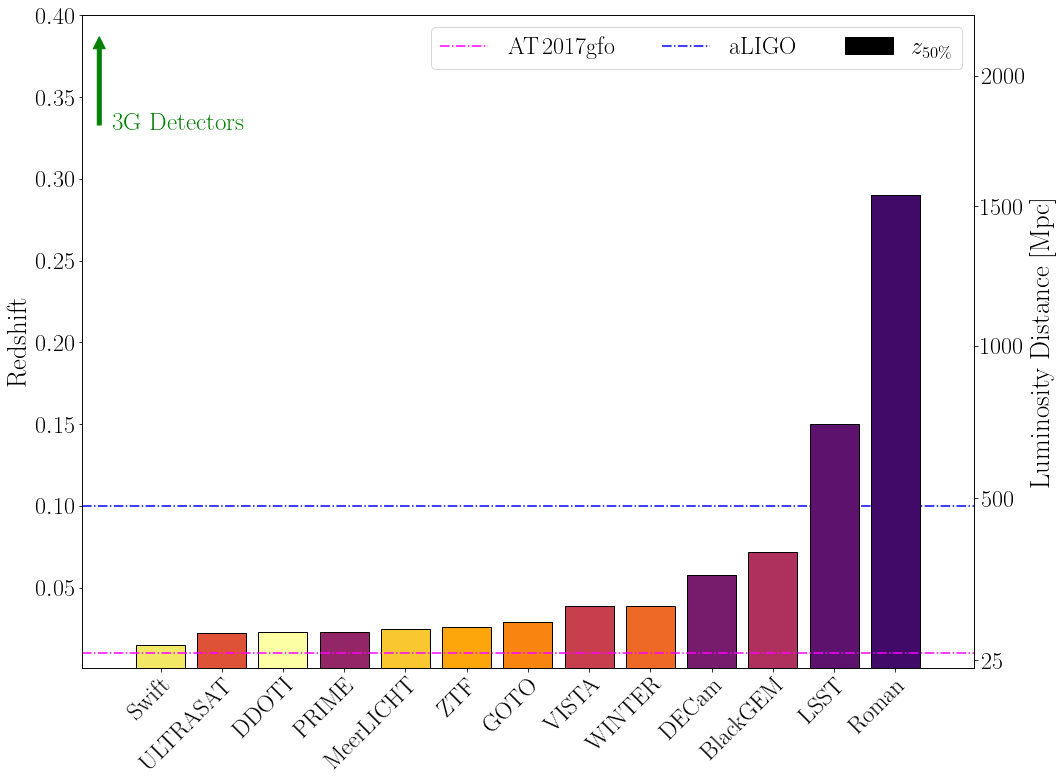

In [7]:
ax = make_bar_chart(filter_data.sort_values(by=['z50'], ignore_index=True),
    gwranges='zhoriz', ymax=0.4, arrowbottom=0.33, arrowtop=0.39)
ax.legend(loc='upper right', ncol=3)

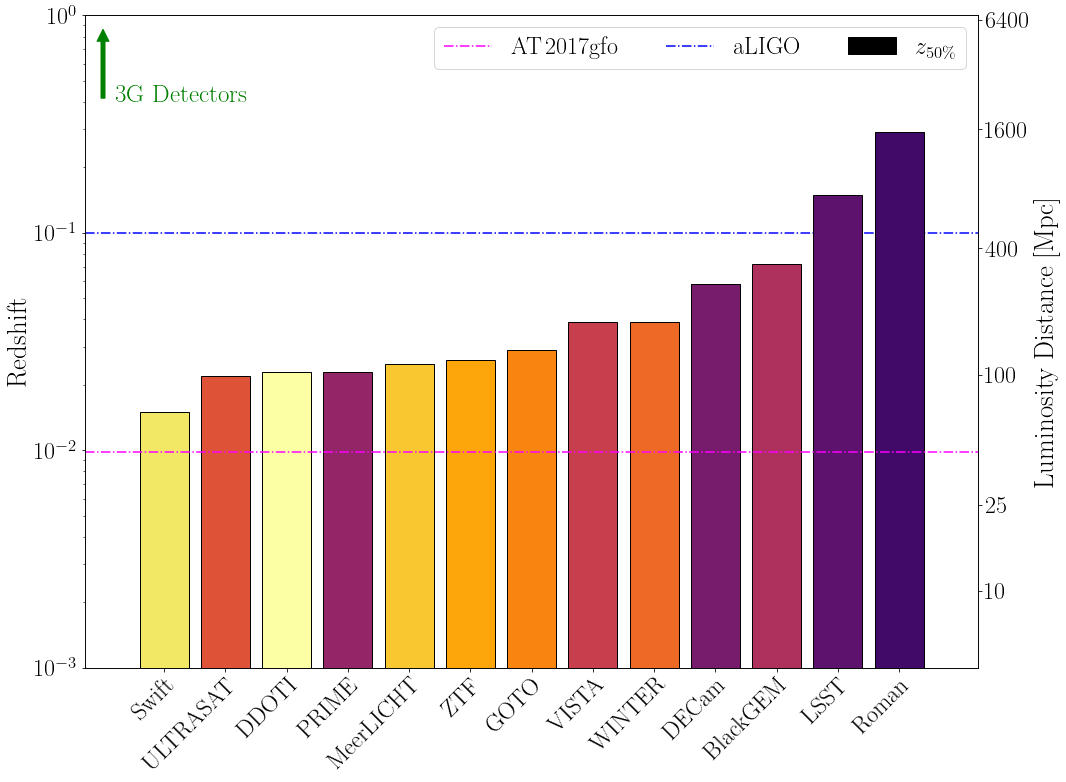

In [427]:
ax = make_bar_chart(filter_data.sort_values(by=['z50'], ignore_index=True),
    log=True, ymax=1, gwranges='zhoriz', arrowbottom=0.4, arrowtop=0.9)
ax.legend(loc='upper right', ncol=3)

# Temporal Variation

# Log

### Ordered by overall z50

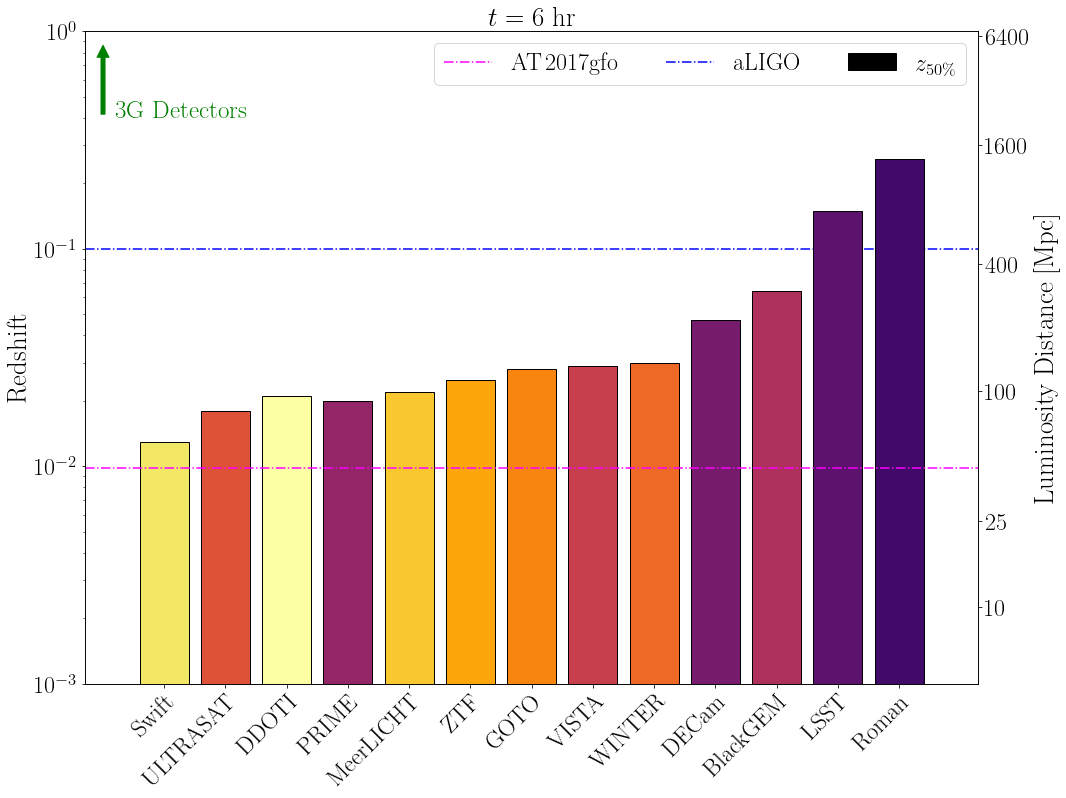

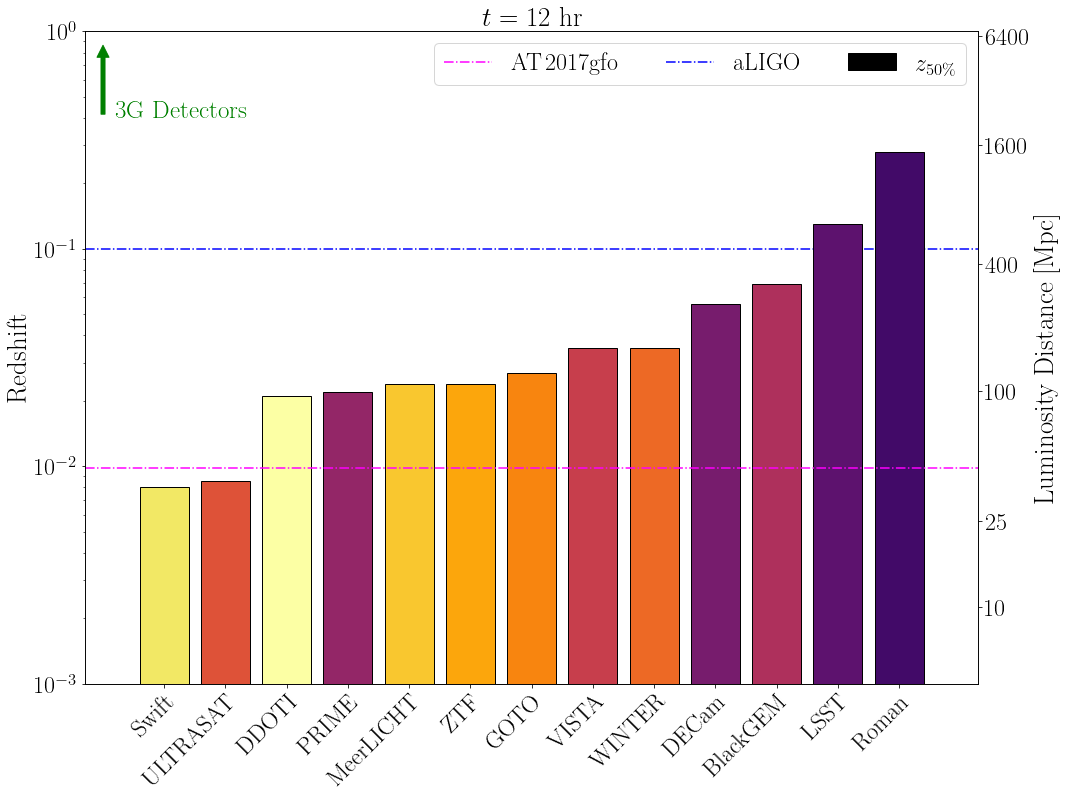

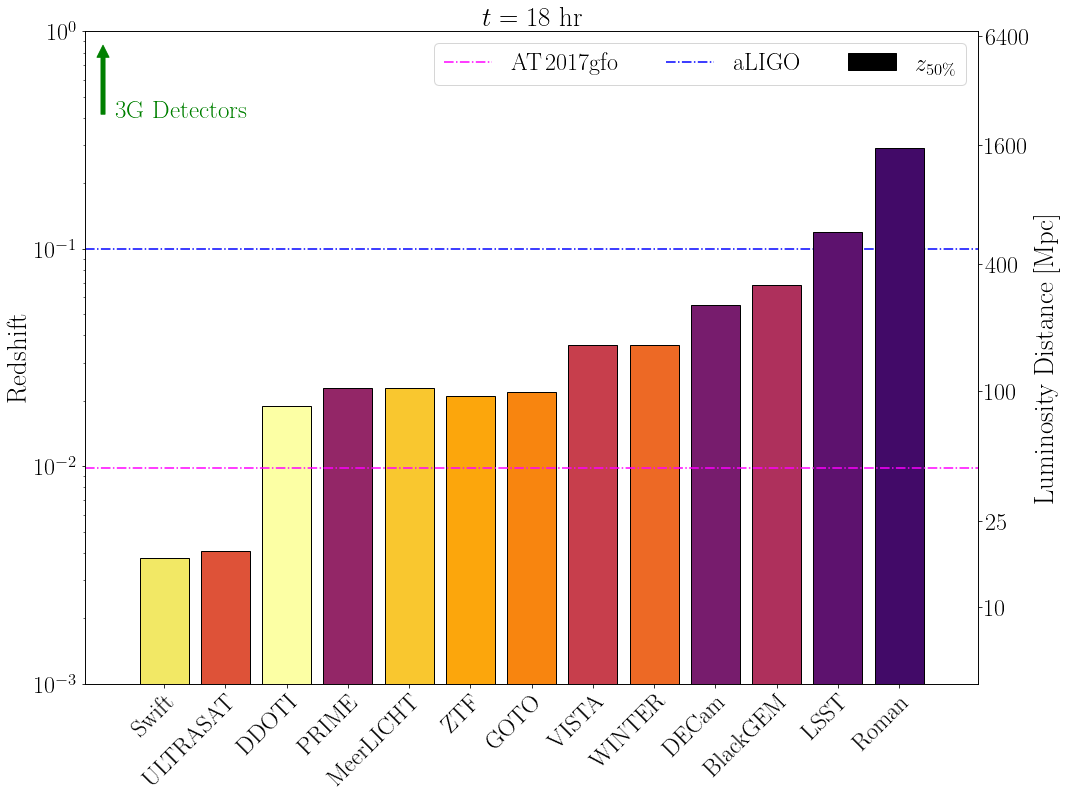

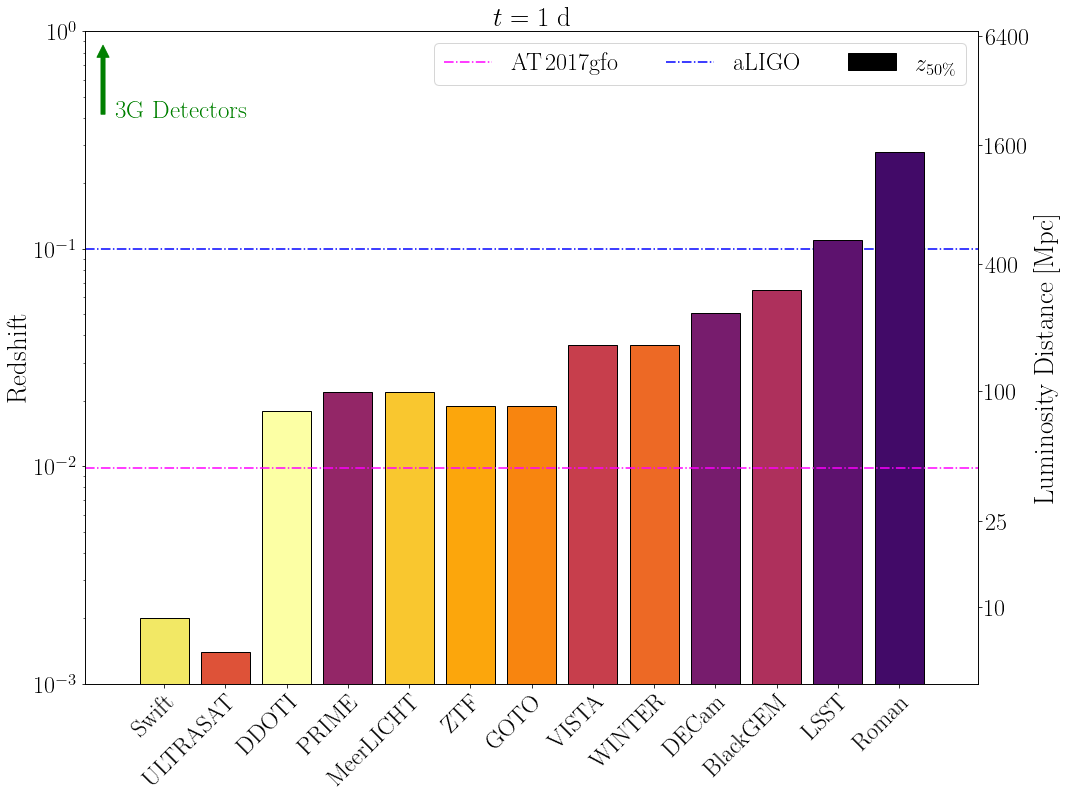

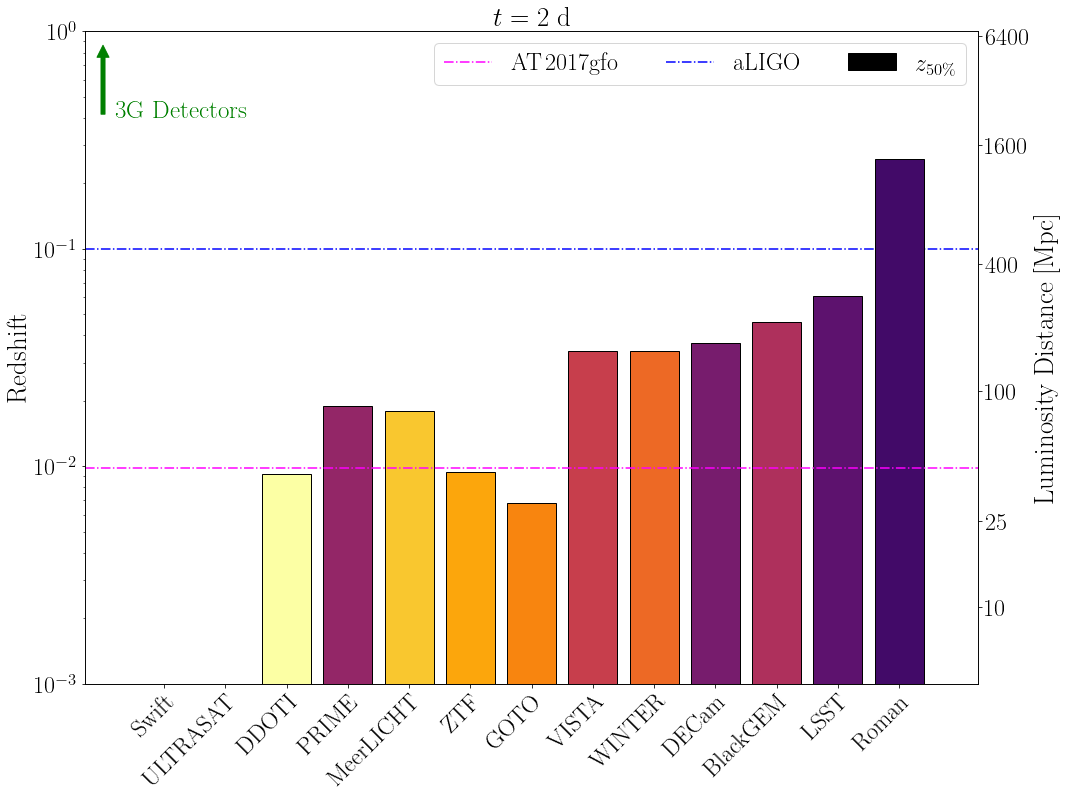

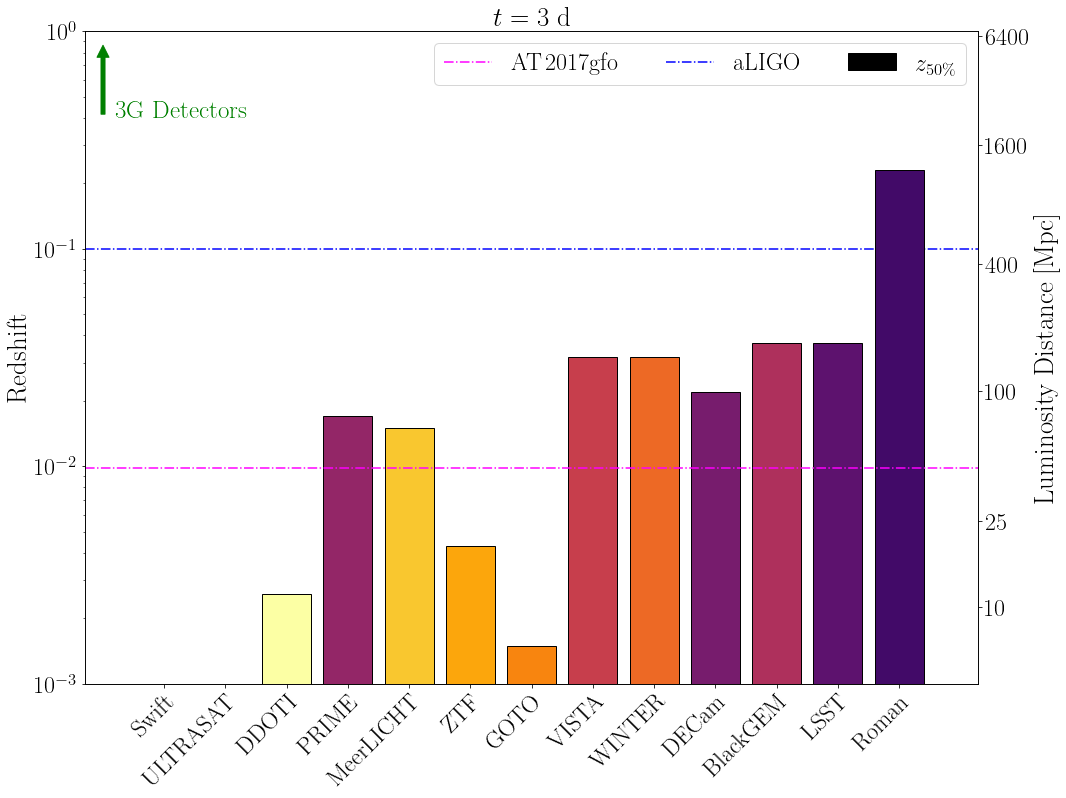

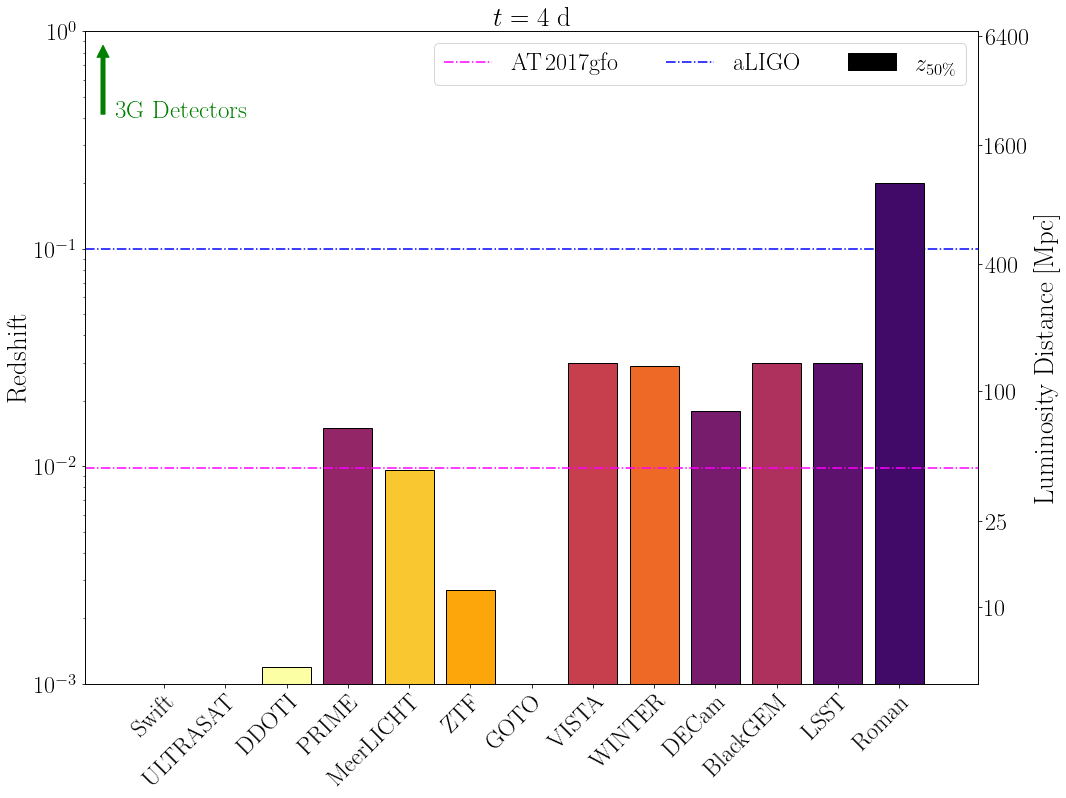

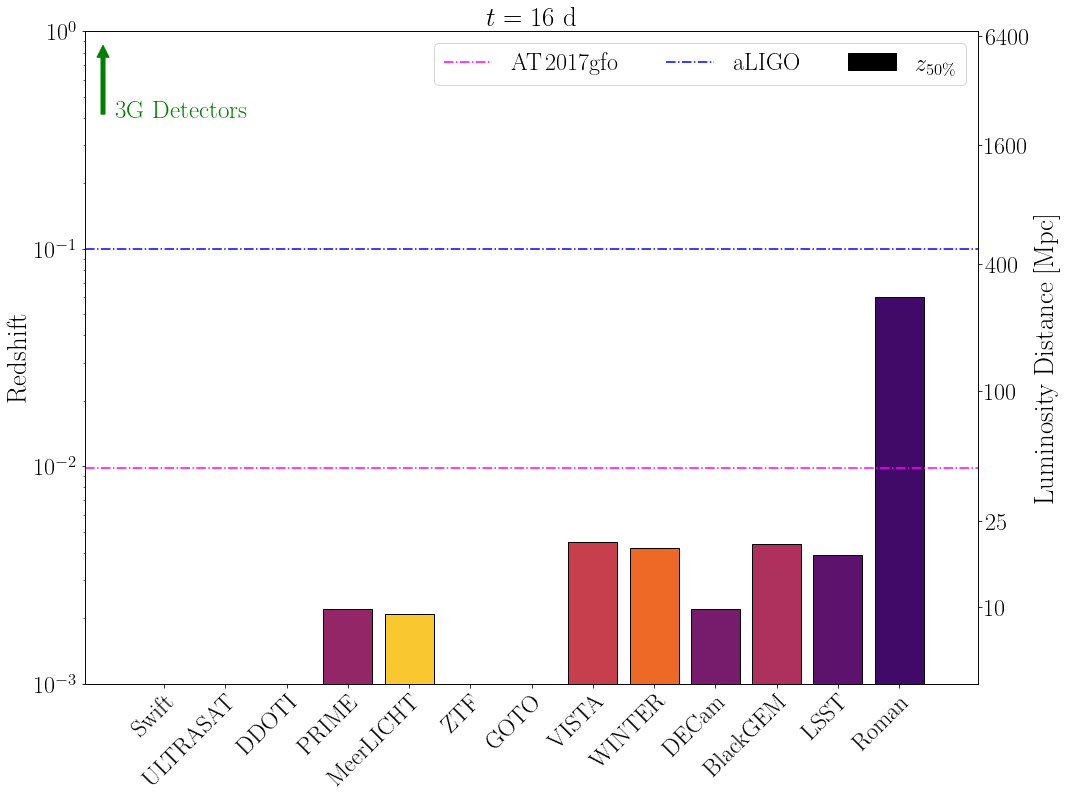

In [428]:
for time in [6, 12, 18, 24, 48, 72, 96, 384]:
    ax = make_bar_chart(filter_data.sort_values(by=['z50'], ignore_index=True),
        log=True, ymax=1, gwranges='zhoriz', arrowbottom=0.4, arrowtop=0.9, time=time)
    ax.legend(loc='upper right', ncol=3)
    plt.savefig(f'/Users/r349989/Documents/kilonovae/projects/kilonova_detectability/figures/bar_charts/log_fixedorder_{time}.png')

## Ordered by z50 at time

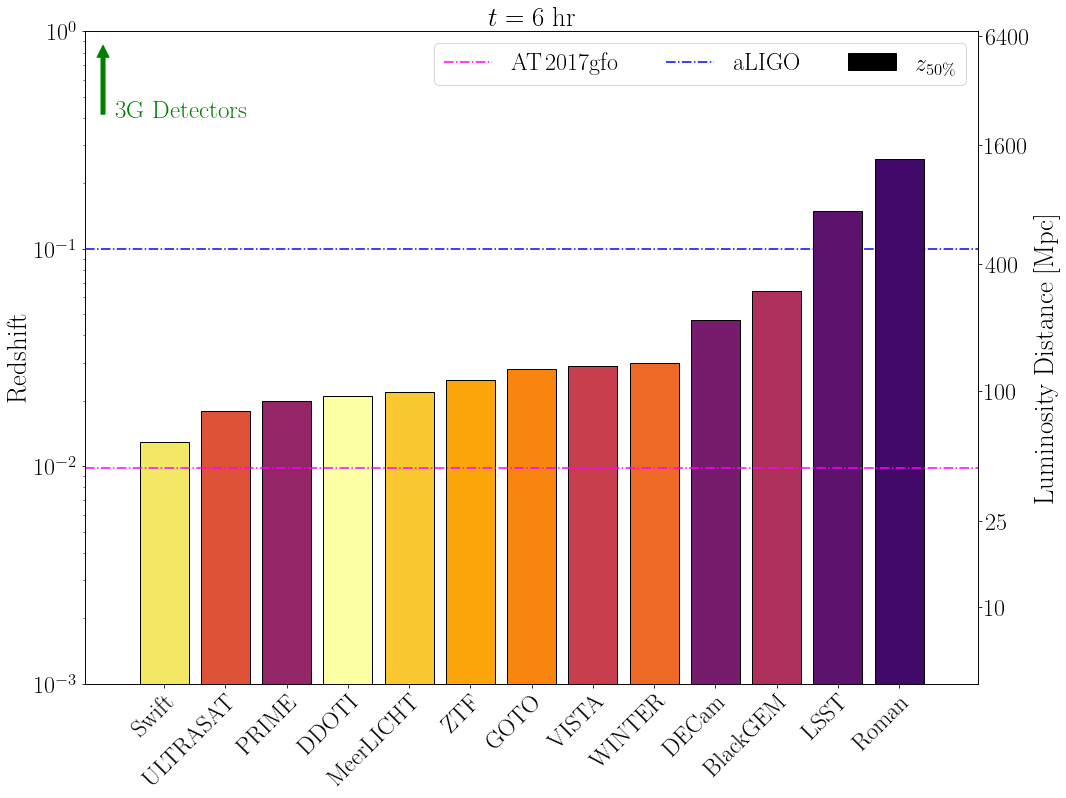

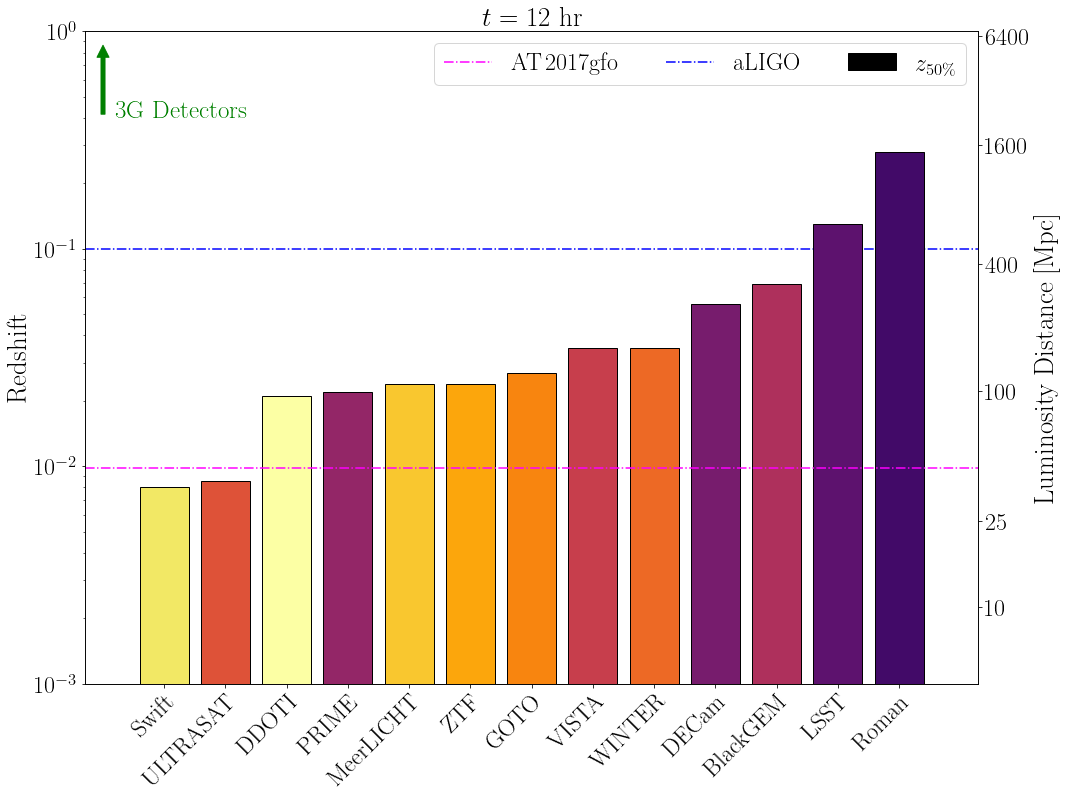

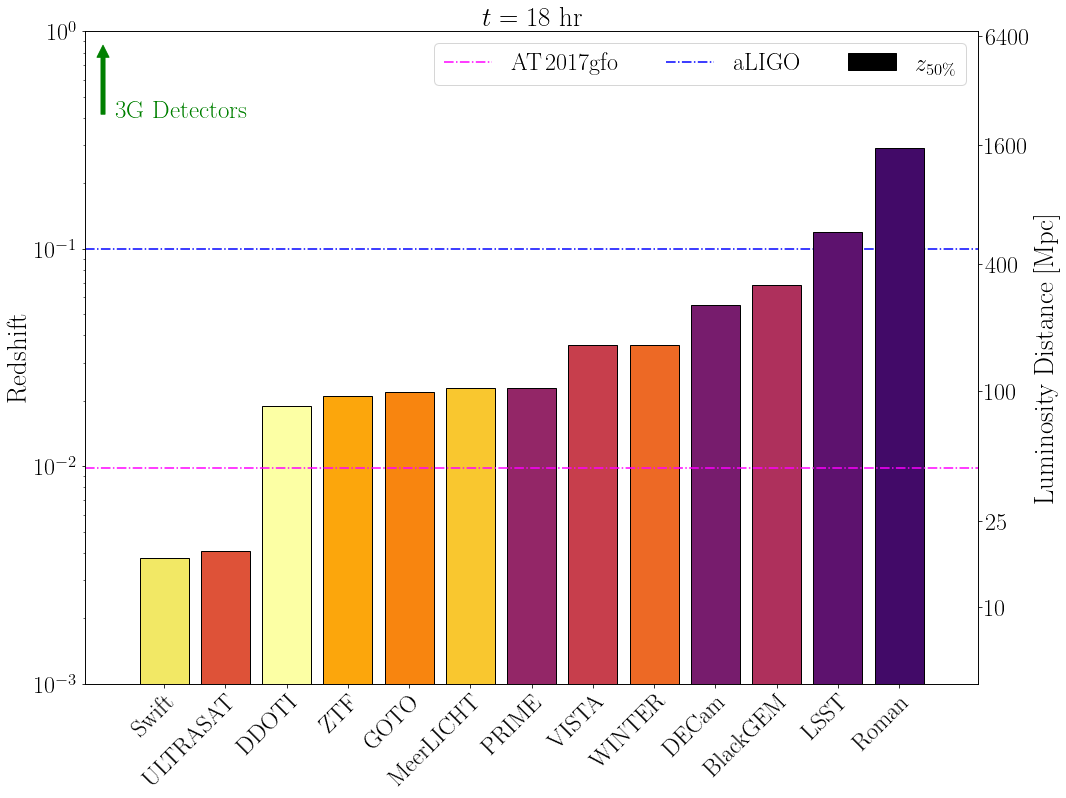

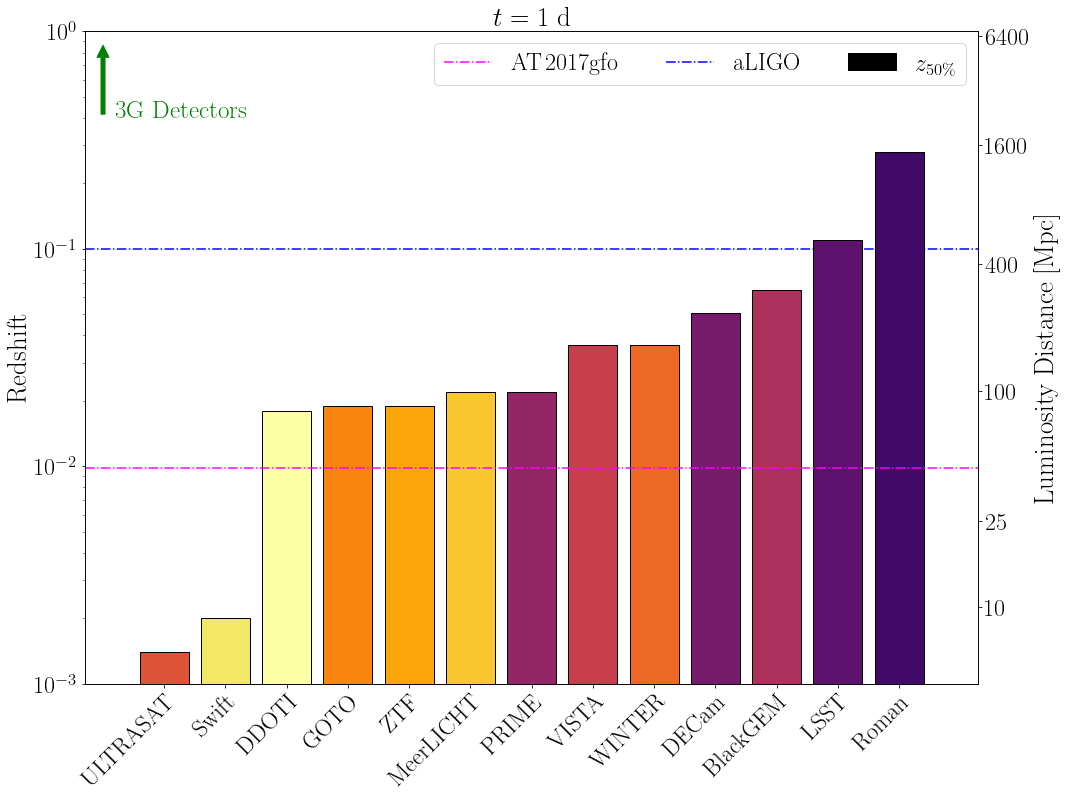

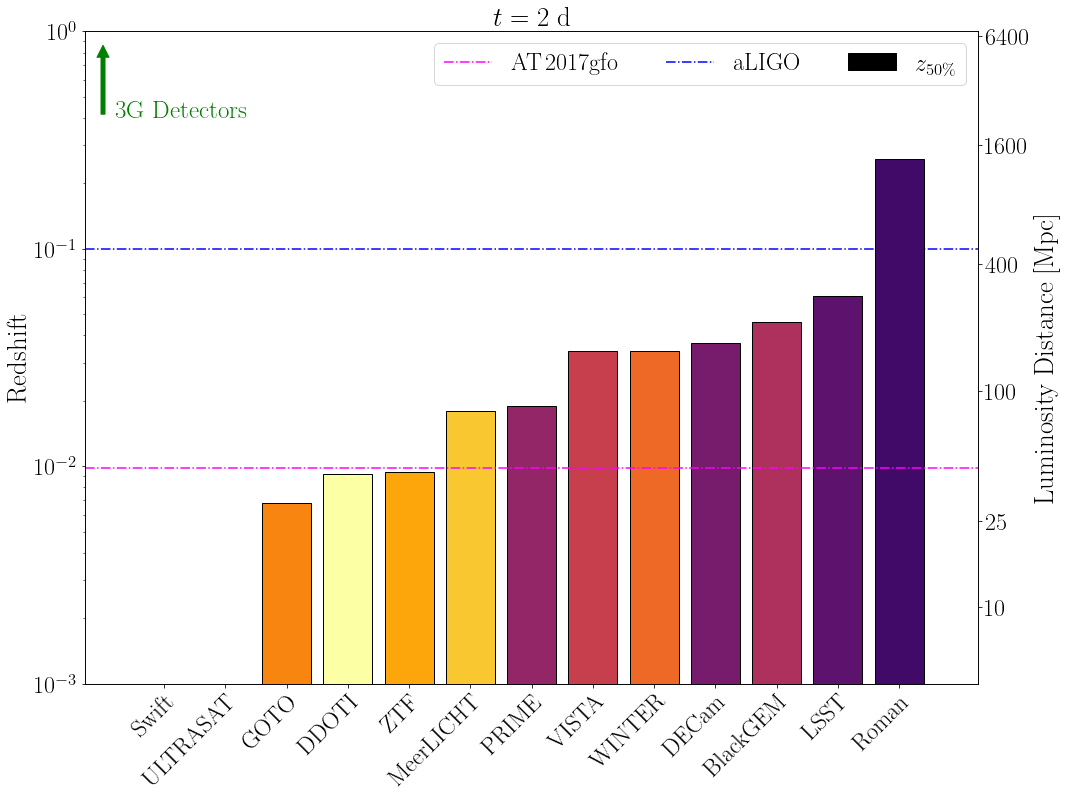

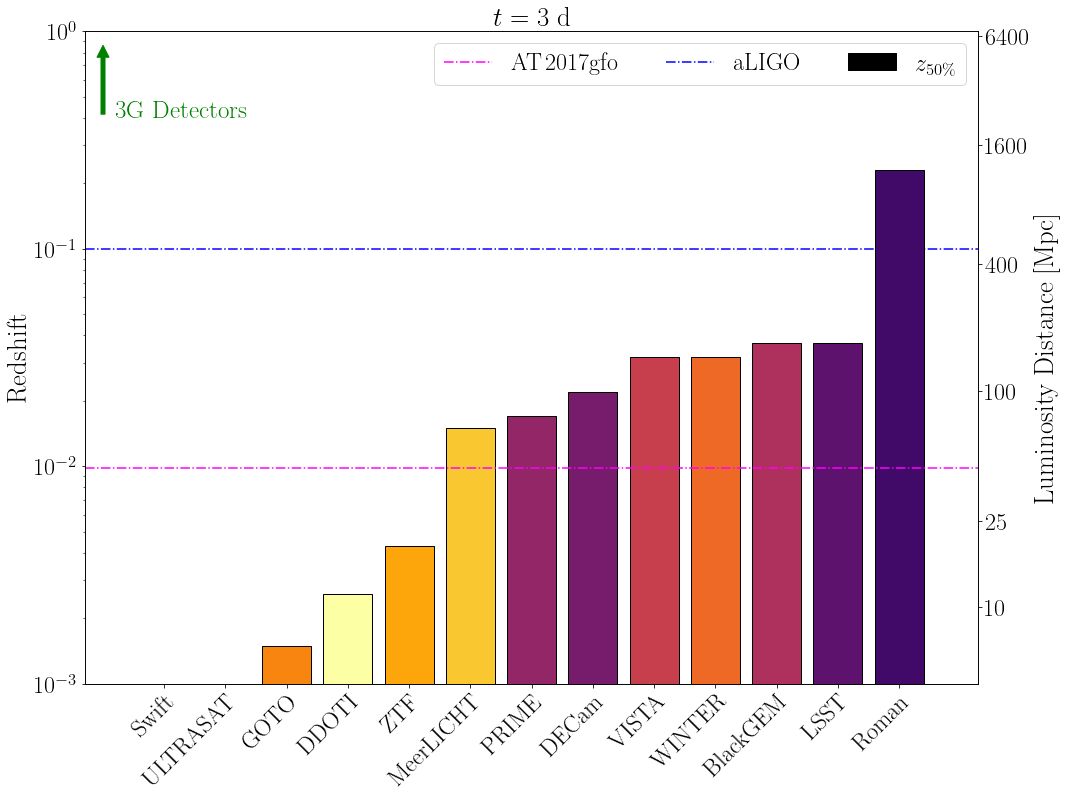

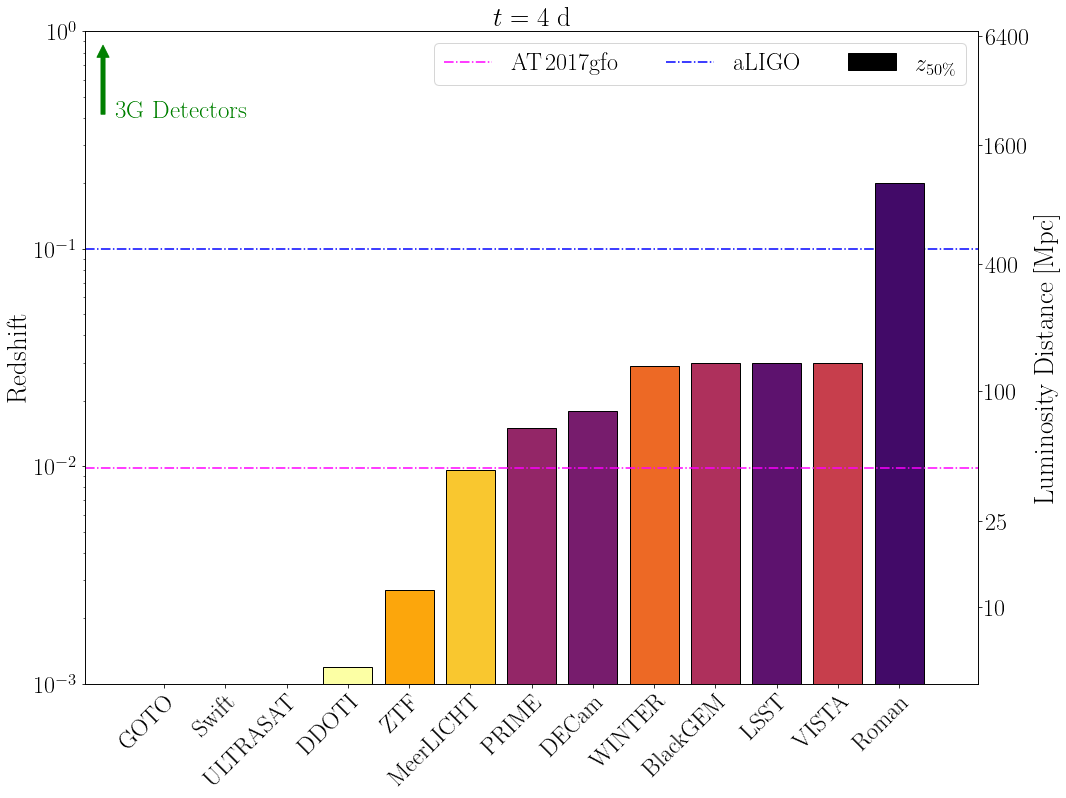

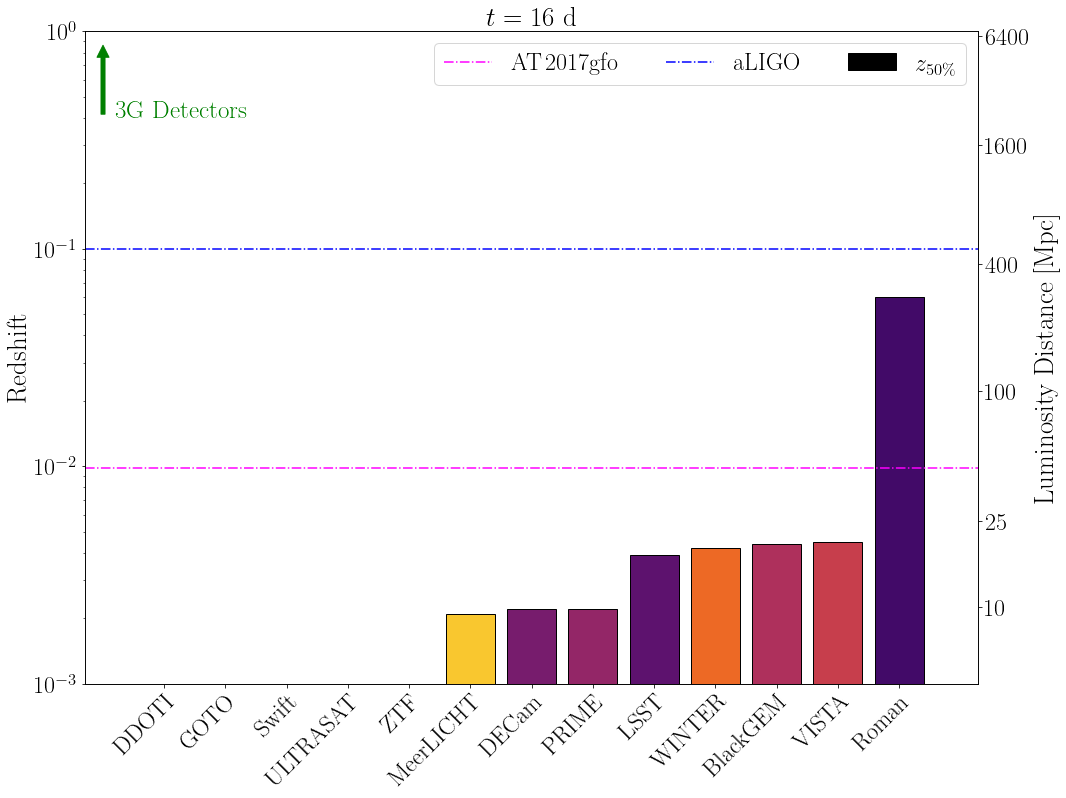

In [429]:
for time in [6, 12, 18, 24, 48, 72, 96, 384]:
    ax = make_bar_chart(filter_data.sort_values(by=[f'z50_t{time}'], ignore_index=True),
        log=True, ymax=1, gwranges='zhoriz', arrowbottom=0.4, arrowtop=0.9, time=time)
    ax.legend(loc='upper right', ncol=3)
    plt.savefig(f'/Users/r349989/Documents/kilonovae/projects/kilonova_detectability/figures/bar_charts/log_alterorder_{time}.png')

# Linear

### Ordered by overall z50

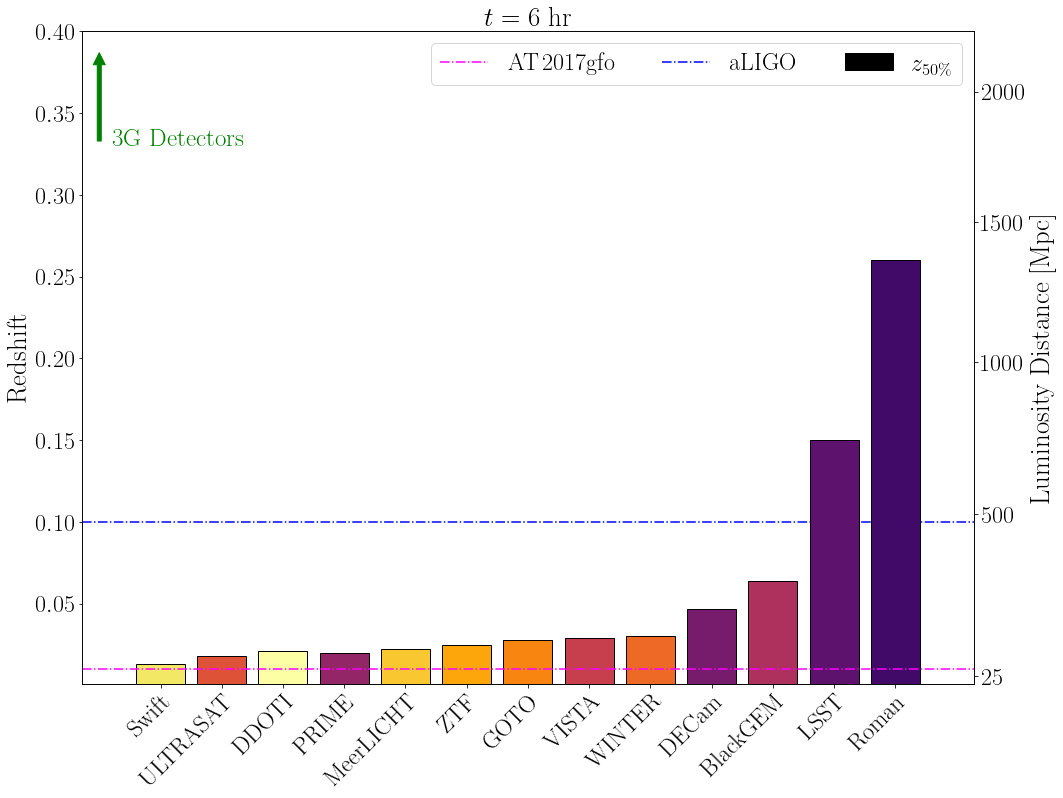

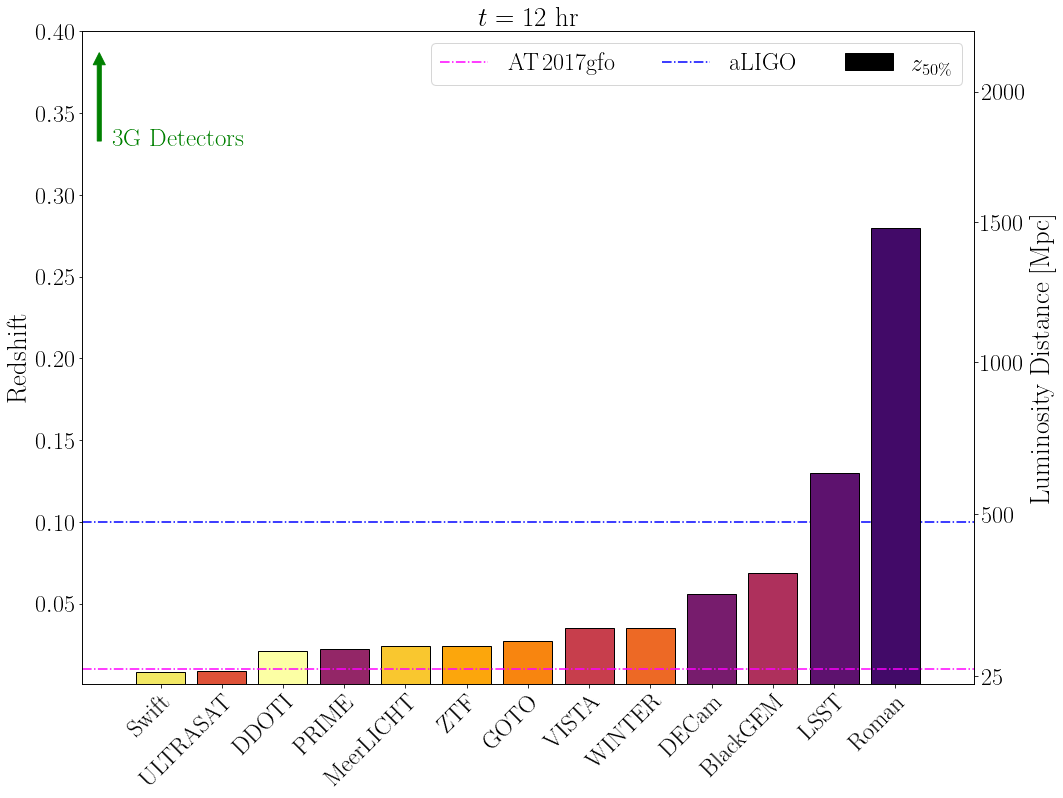

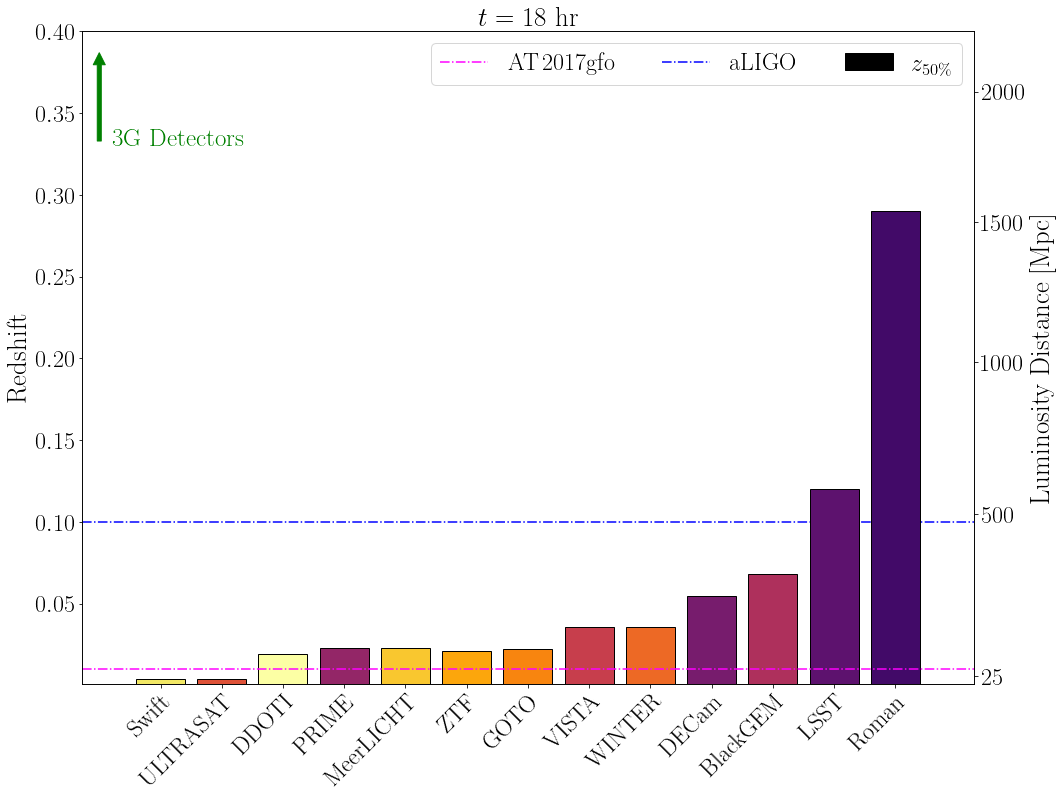

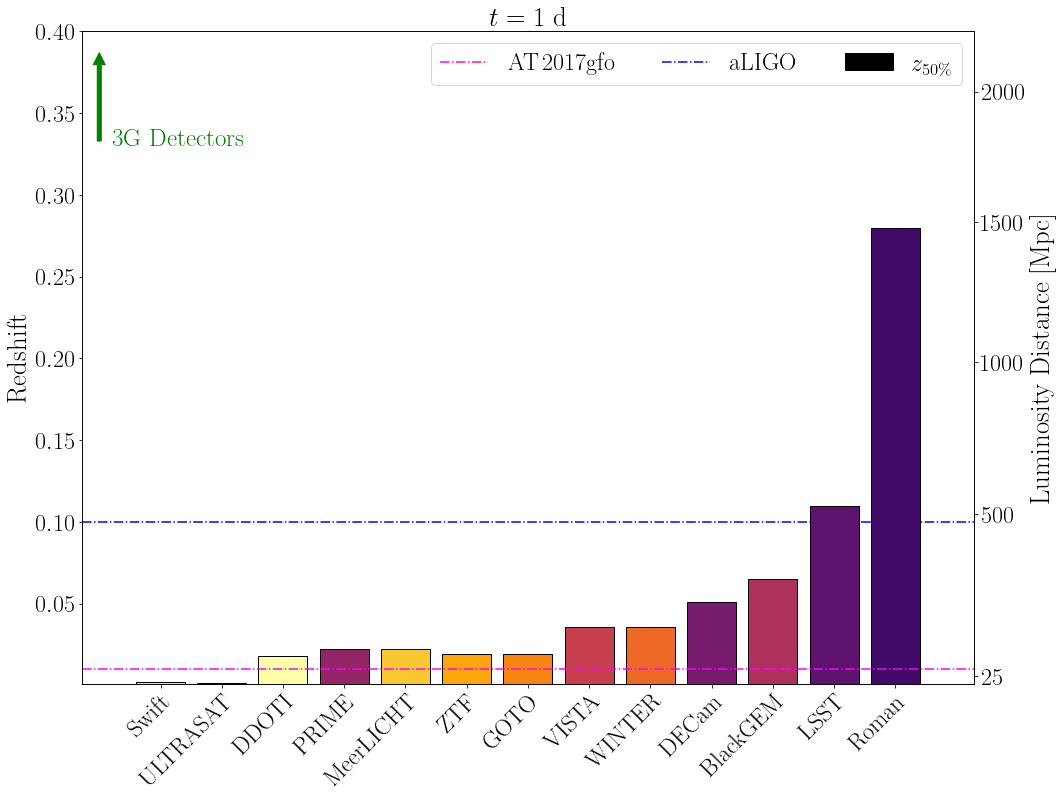

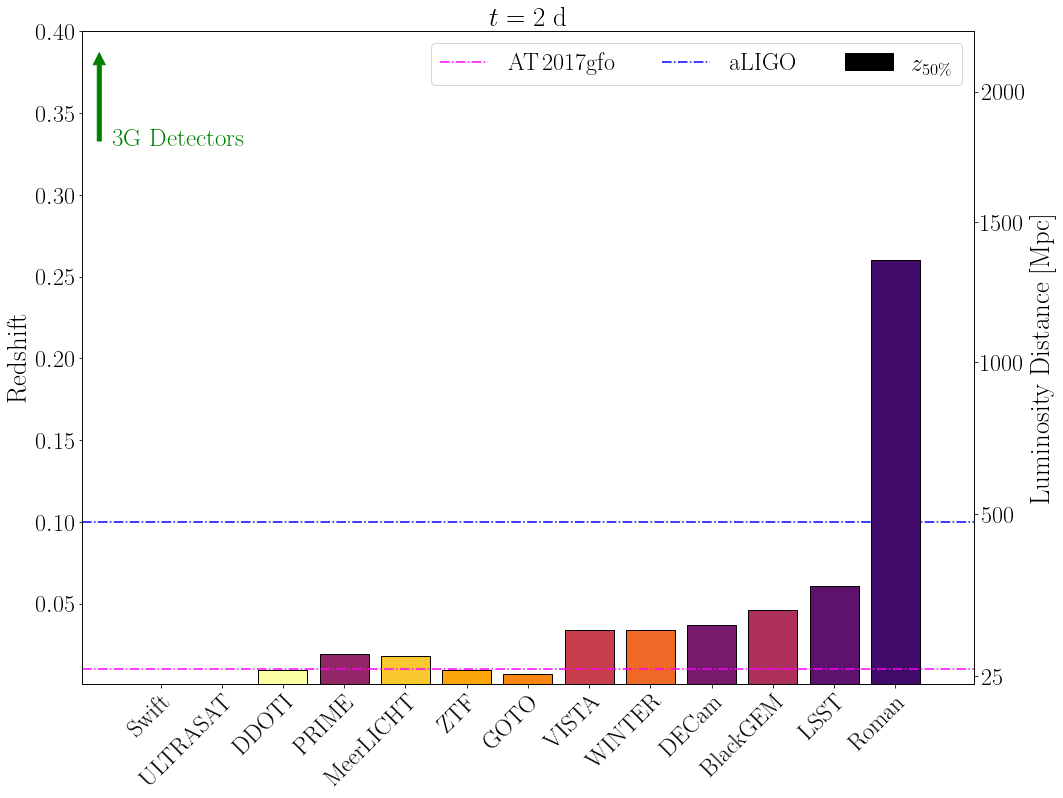

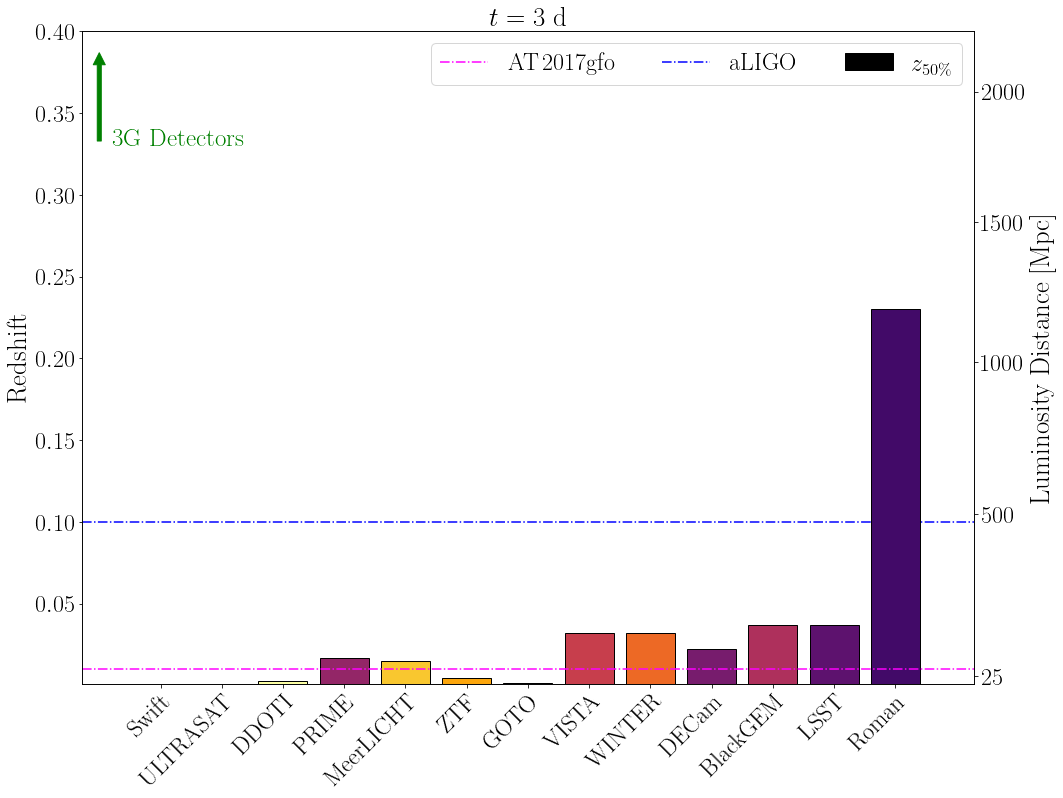

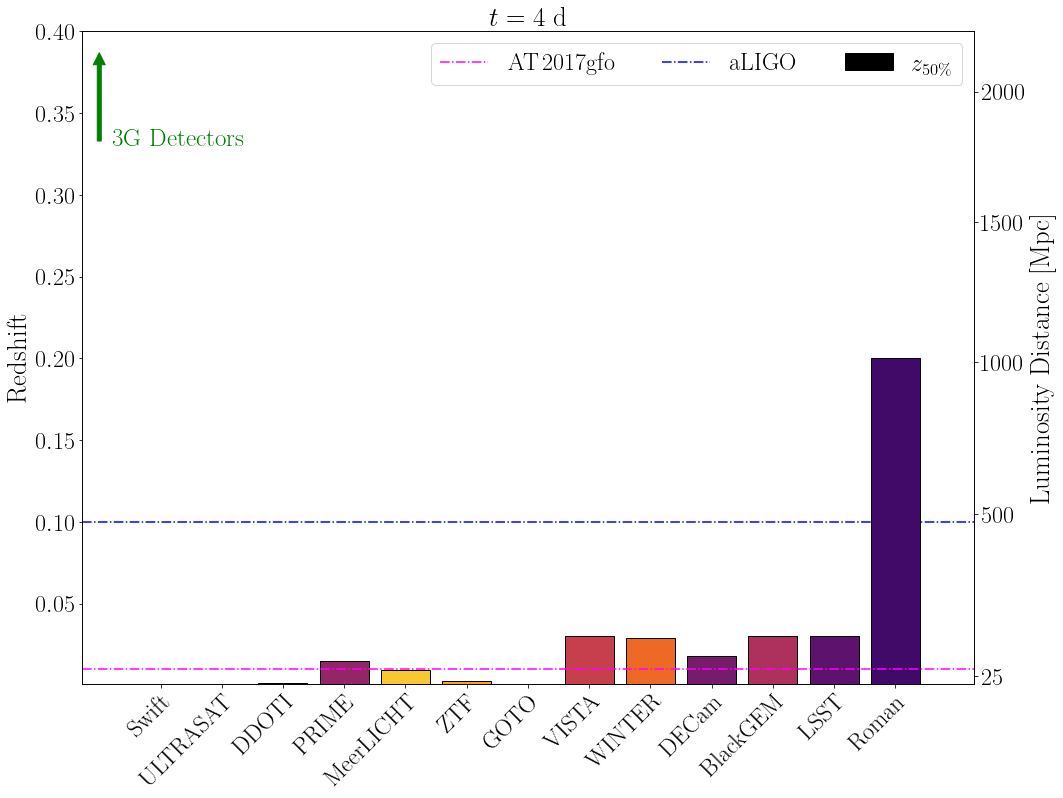

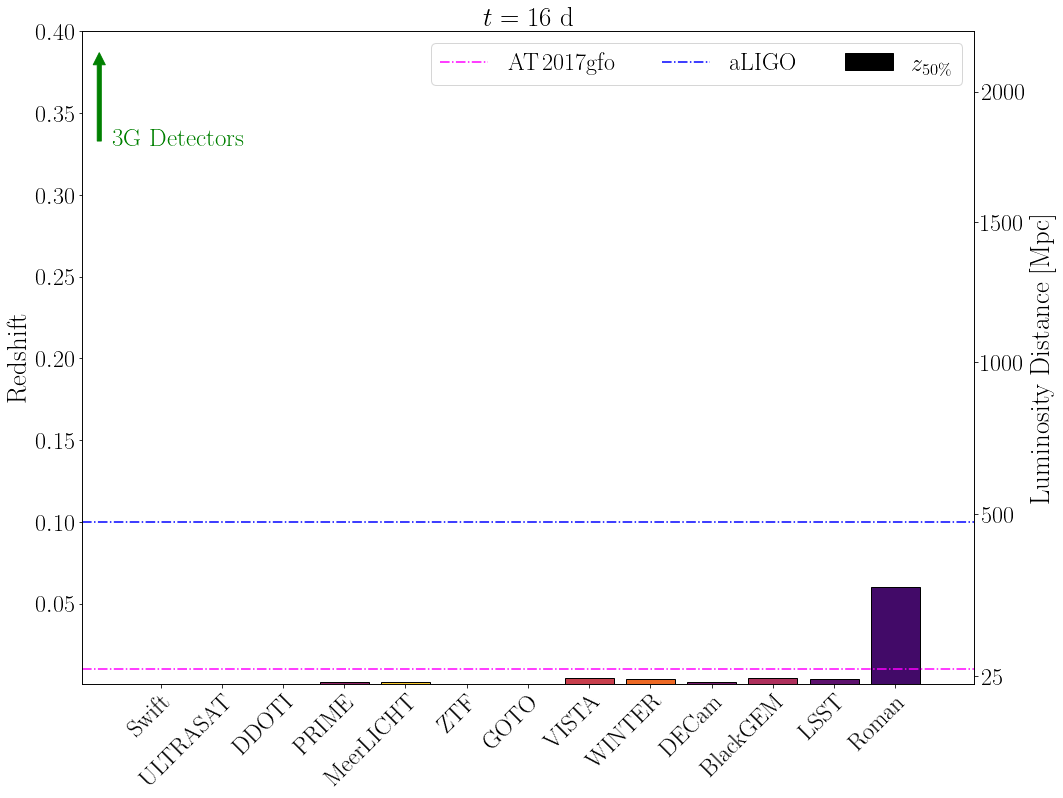

In [430]:
for time in [6, 12, 18, 24, 48, 72, 96, 384]:
    ax = make_bar_chart(filter_data.sort_values(by=['z50'], ignore_index=True),
        log=False, gwranges='zhoriz', ymax=0.4, arrowbottom=0.33, arrowtop=0.39,
        time=time)
    ax.legend(loc='upper right', ncol=3)
    plt.savefig(f'/Users/r349989/Documents/kilonovae/projects/kilonova_detectability/figures/bar_charts/linear_fixedorder_{time}.png')

### Ordered by z50 at time

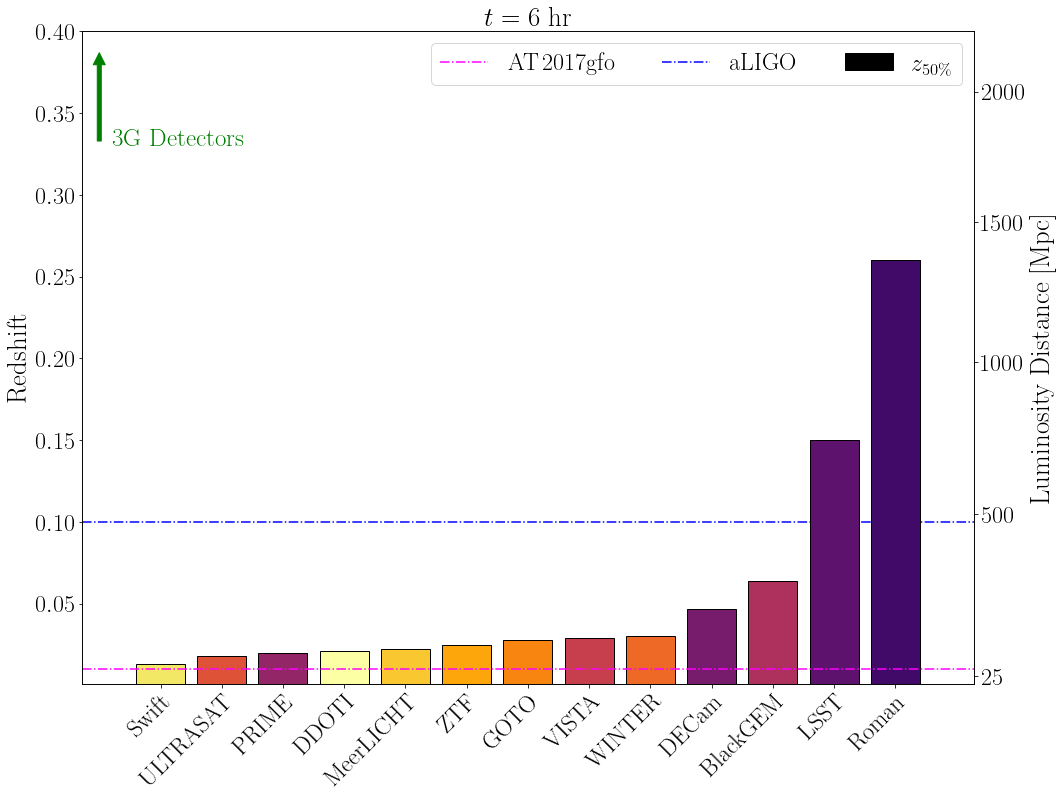

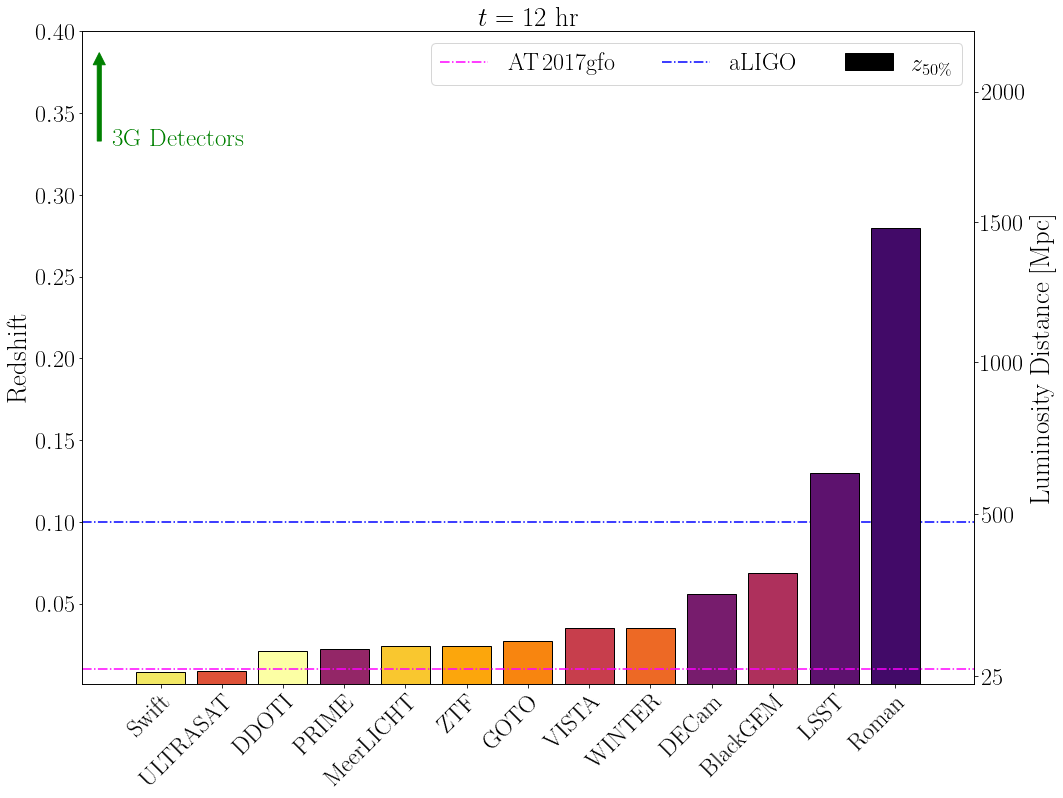

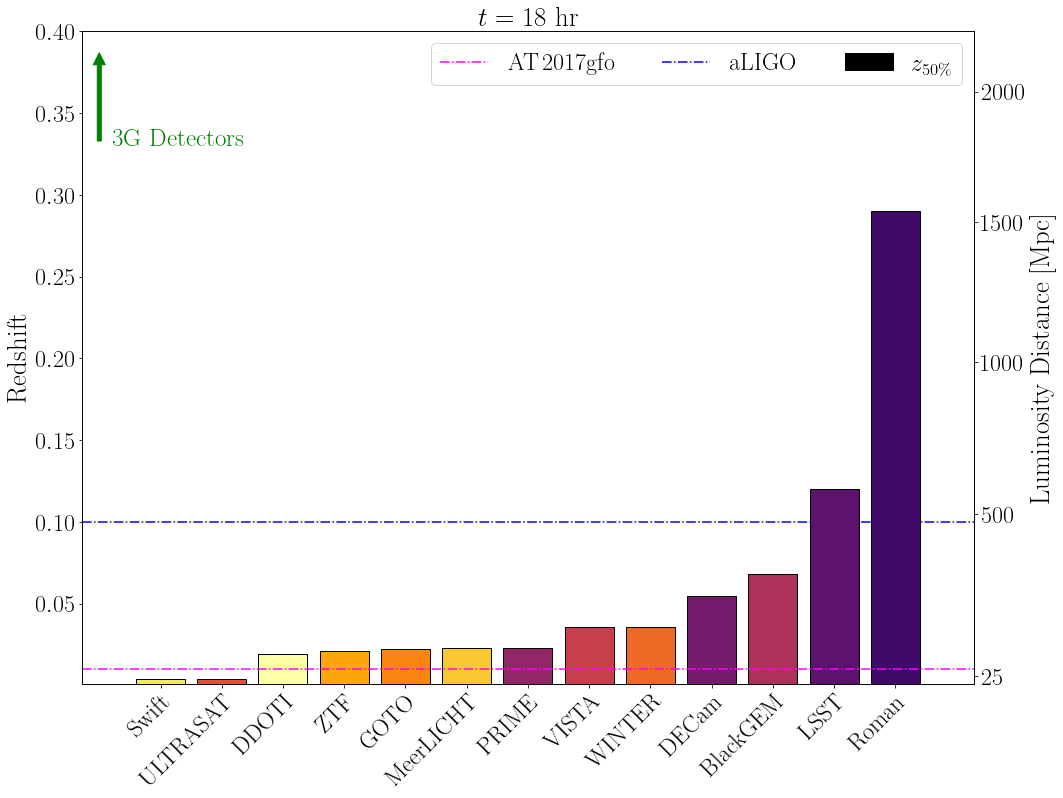

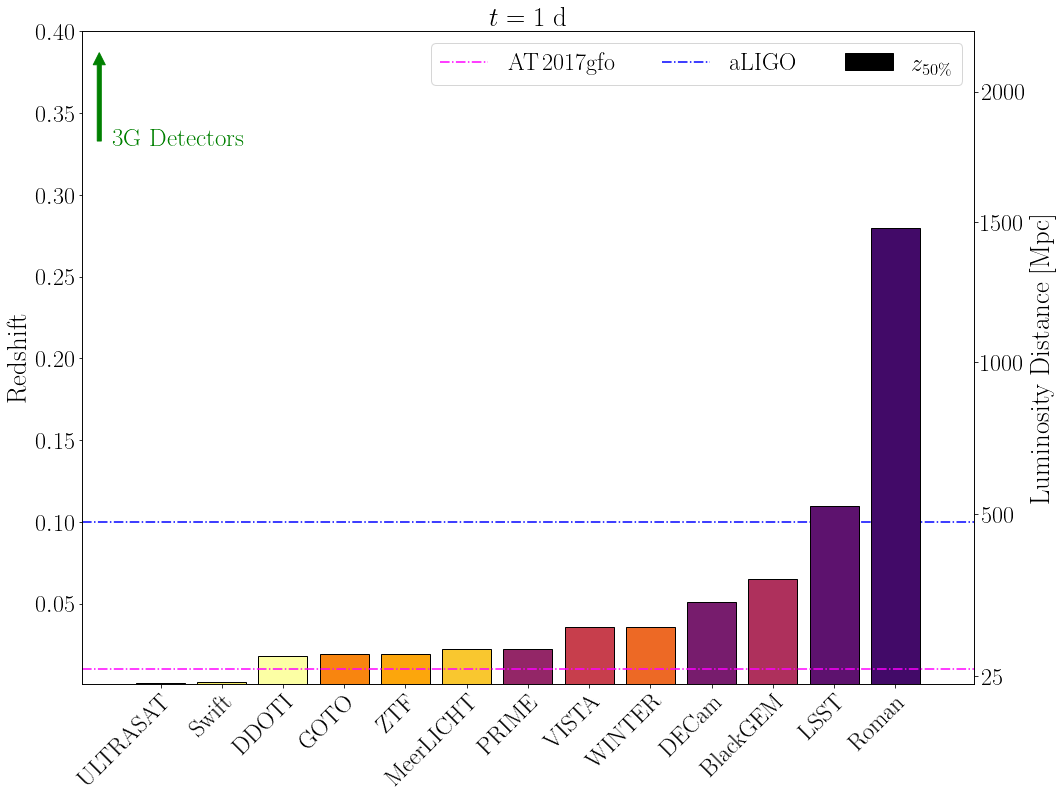

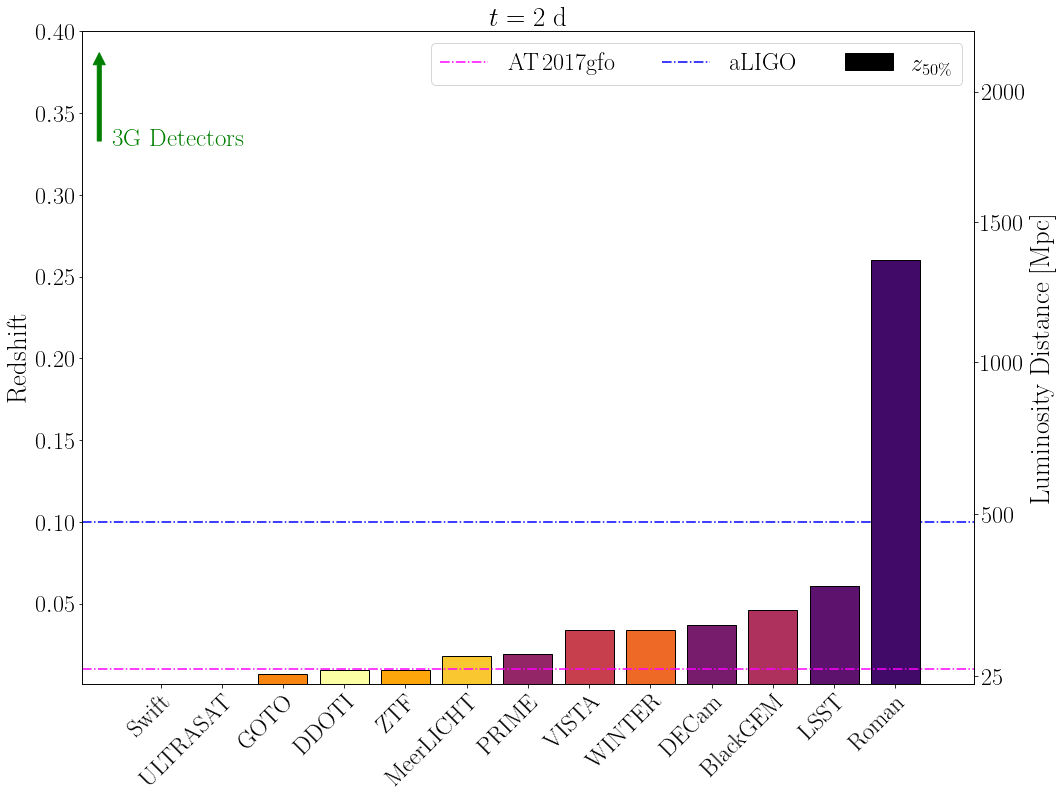

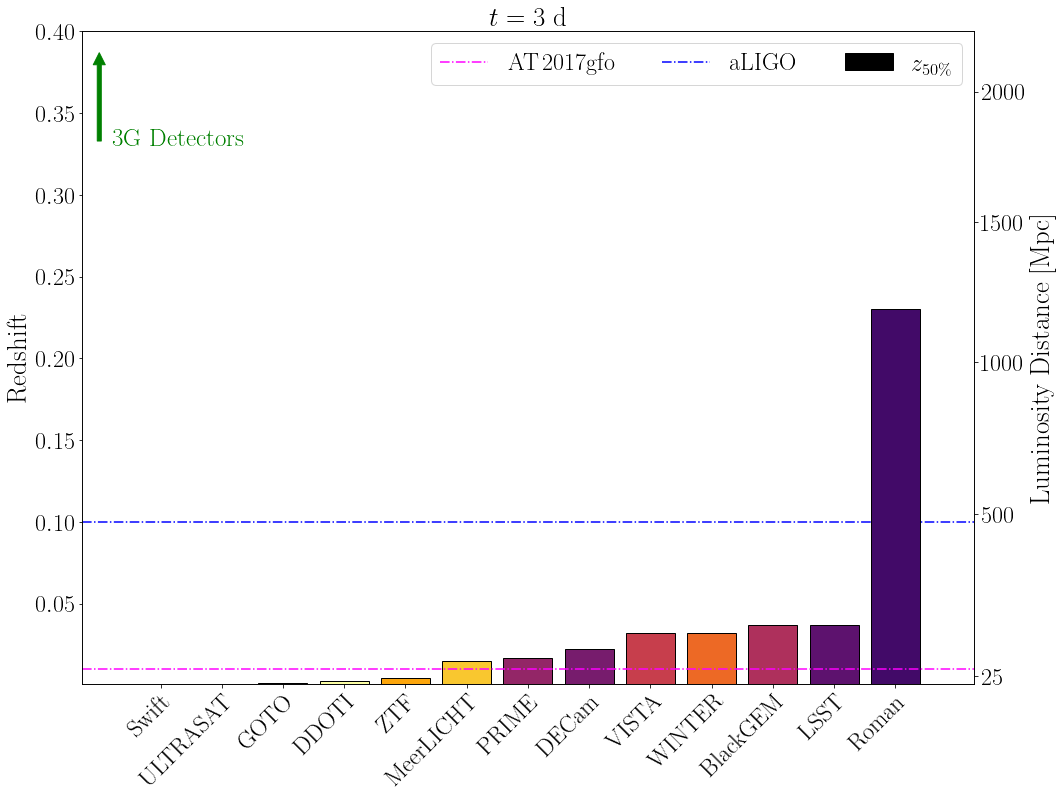

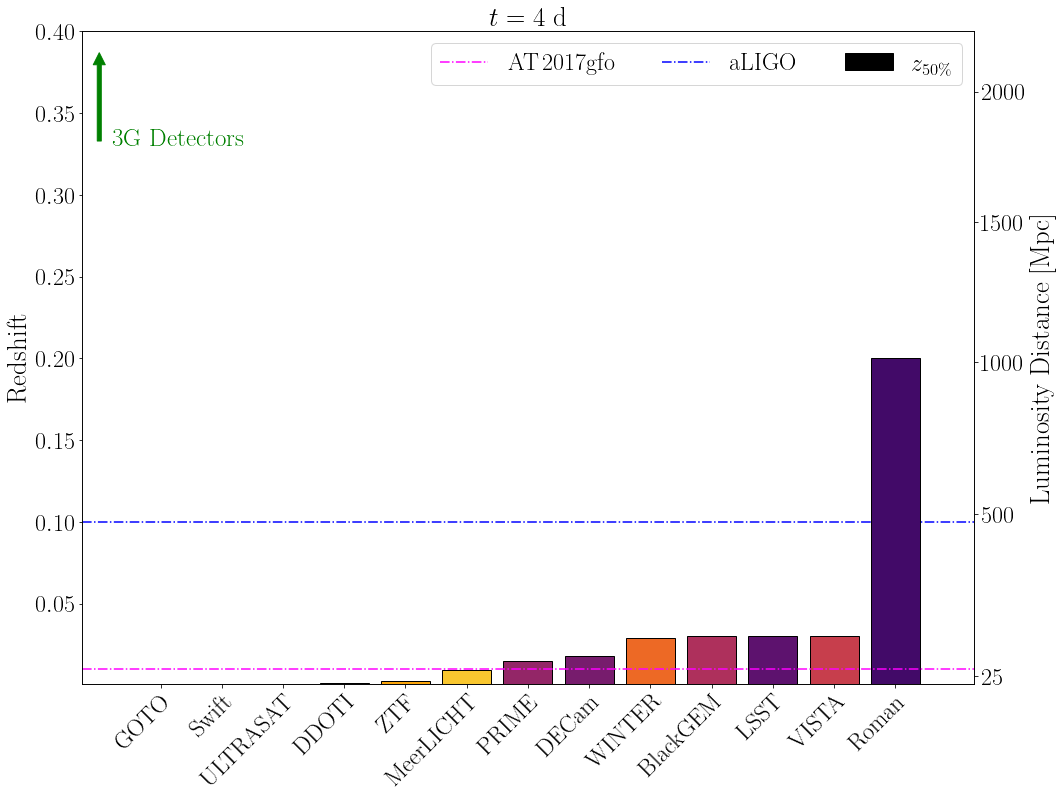

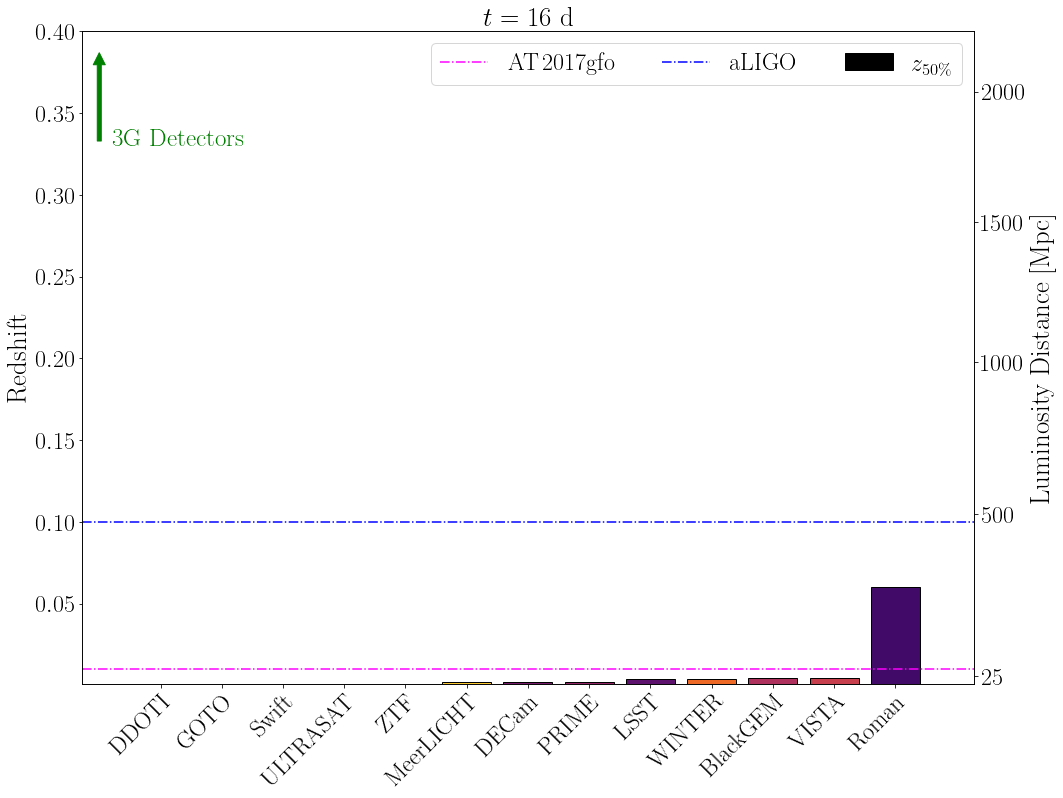

In [9]:
for time in [6, 12, 18, 24, 48, 72, 96, 384]:
    ax = make_bar_chart(filter_data.sort_values(by=[f'z50_t{time}'], ignore_index=True),
        log=False, gwranges='zhoriz', ymax=0.4, arrowbottom=0.33, arrowtop=0.39,
        time=time)
    ax.legend(loc='upper right', ncol=3)
    plt.savefig(f'/Users/r349989/Documents/kilonovae/projects/kilonova_detectability/figures/bar_charts/linear_alterorder_{time}.png')

# Bonus Plots

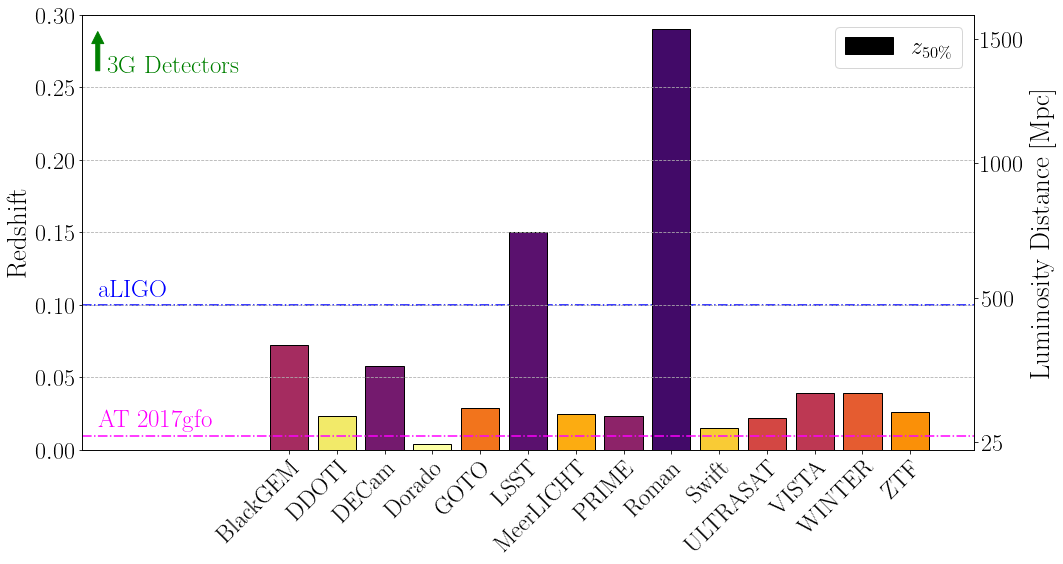

In [333]:
ax = make_bar_chart(filter_data, gwranges='zhoriz')
ax.legend(loc='upper right')

<AxesSubplot:ylabel='Redshift'>

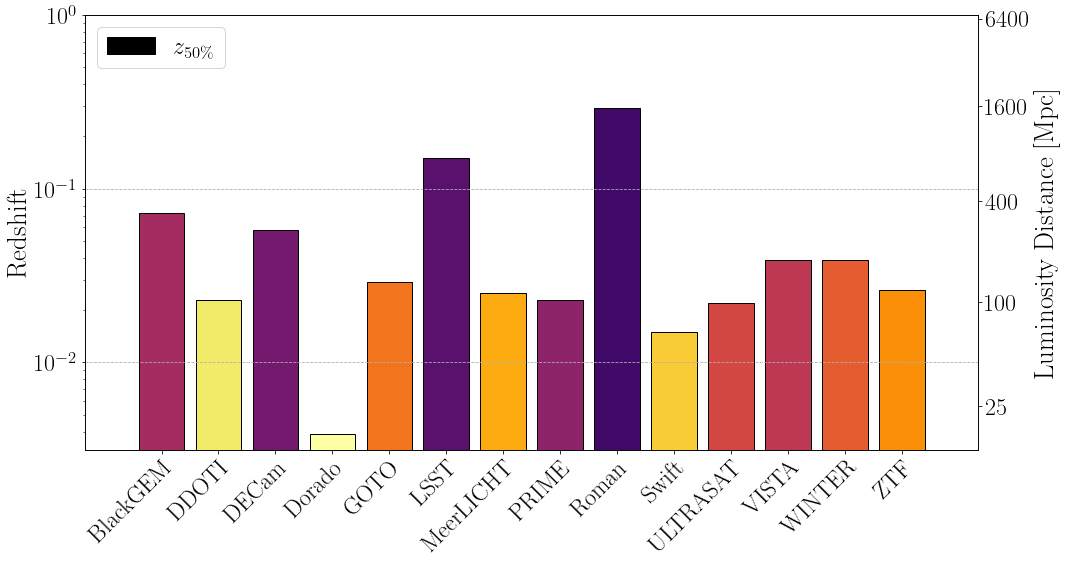

In [334]:
make_bar_chart(filter_data, log=True, ymax=1)

<AxesSubplot:ylabel='Redshift'>

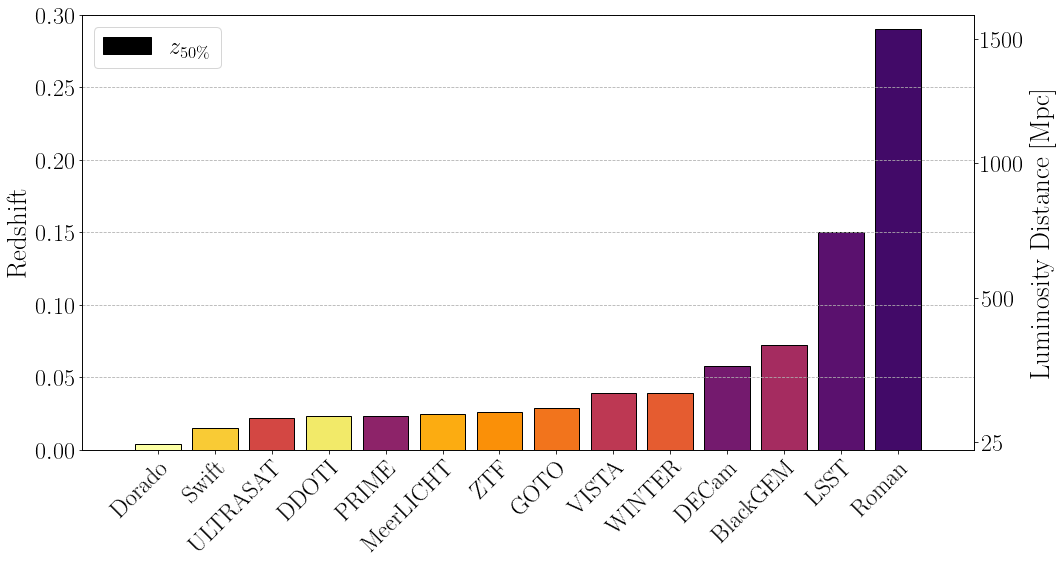

In [335]:
make_bar_chart(filter_data.sort_values(by=['z50'], ignore_index=True))

<AxesSubplot:ylabel='Redshift'>

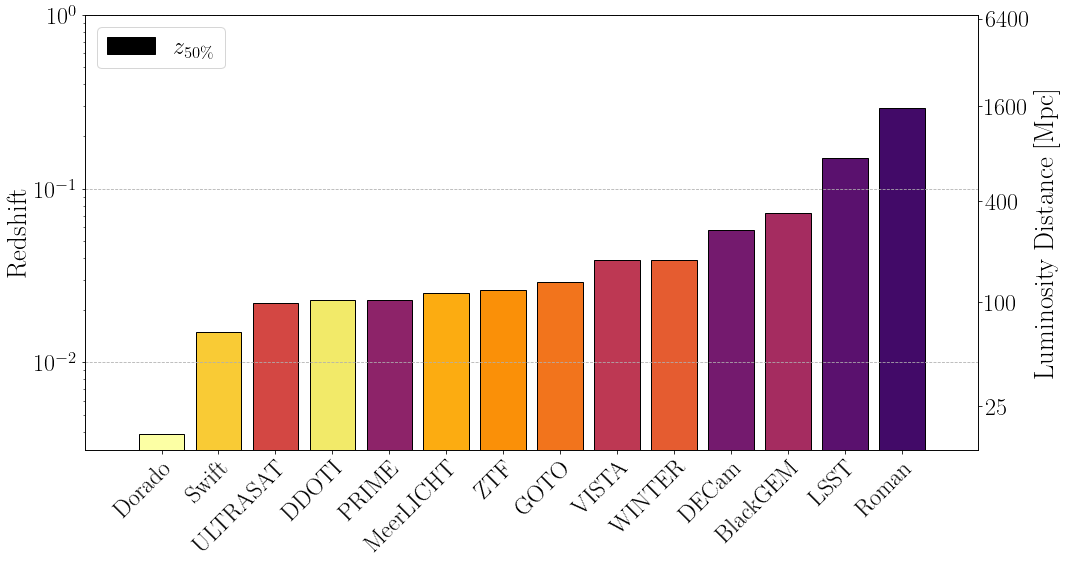

In [337]:
make_bar_chart(filter_data.sort_values(by=['z50'], ignore_index=True),
    log=True, ymax=1)

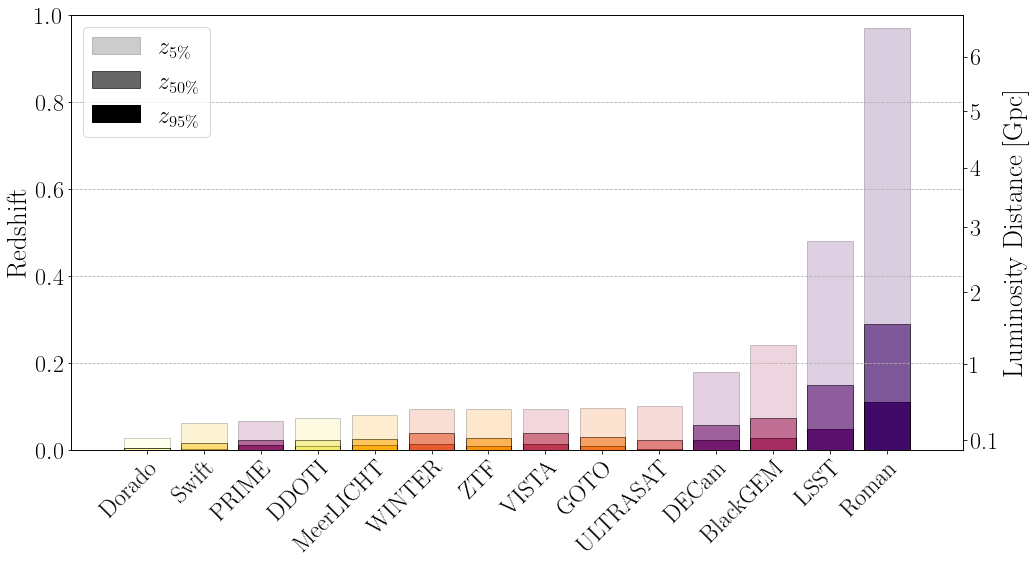

In [339]:
ax = make_bar_chart(filter_data.sort_values(by=['z5'], ignore_index=True),
    fade=True, ymax=1)

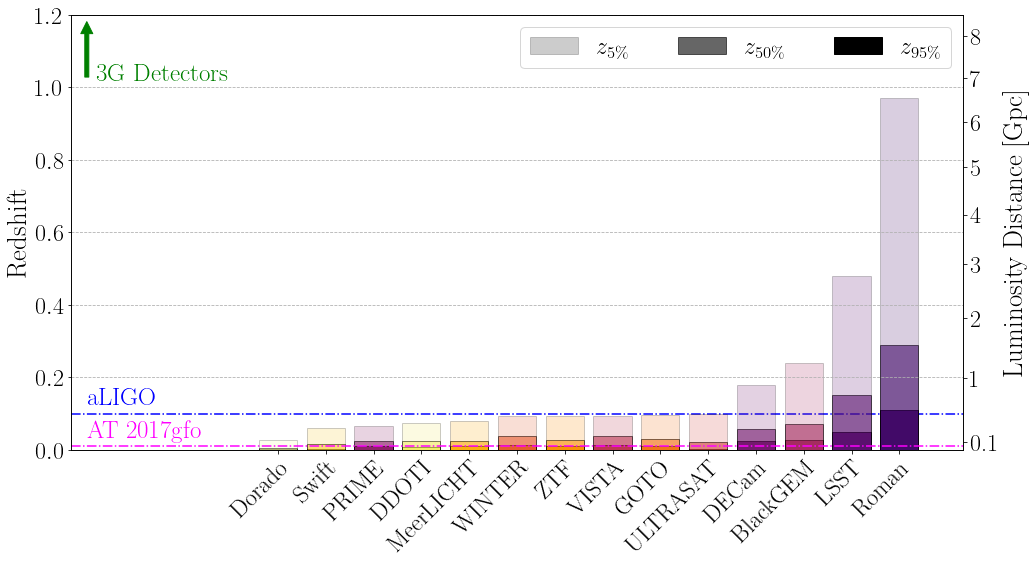

In [340]:
ax = make_bar_chart(filter_data.sort_values(by=['z5'], ignore_index=True),
    fade=True, ymax=1.2, gwranges='zhoriz', arrowbottom=1.02, arrowtop=1.19)
ax.legend(loc='upper right', ncol=3)

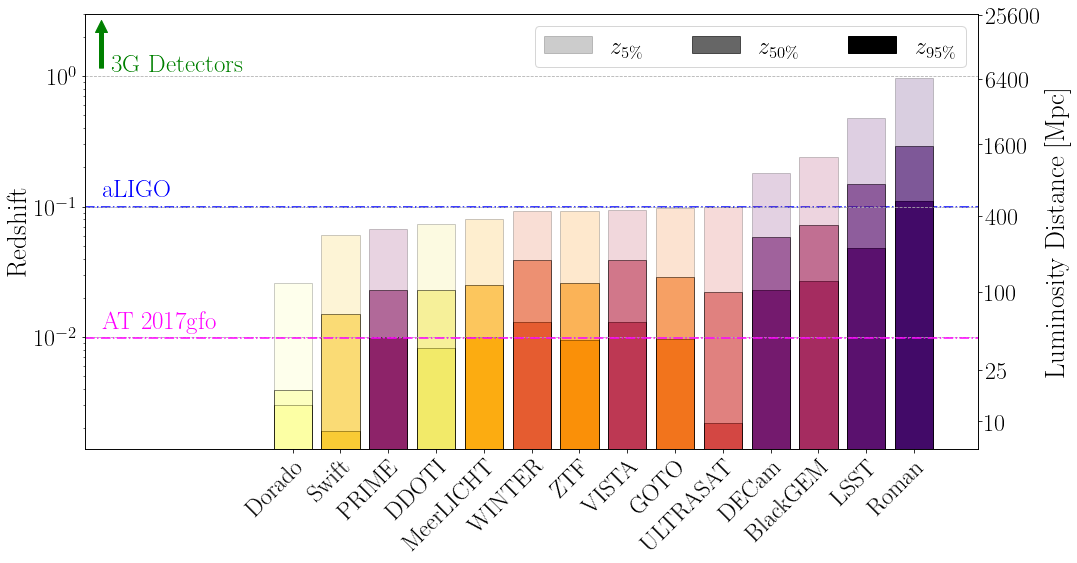

In [347]:
ax = make_bar_chart(filter_data.sort_values(by=['z5'], ignore_index=True),
    fade=True, log=True, ymax=3, gwranges='zhoriz',
    arrowbottom=1.1, arrowtop=2.8)
ax.legend(loc='upper right', ncol=3)


<AxesSubplot:ylabel='Redshift'>

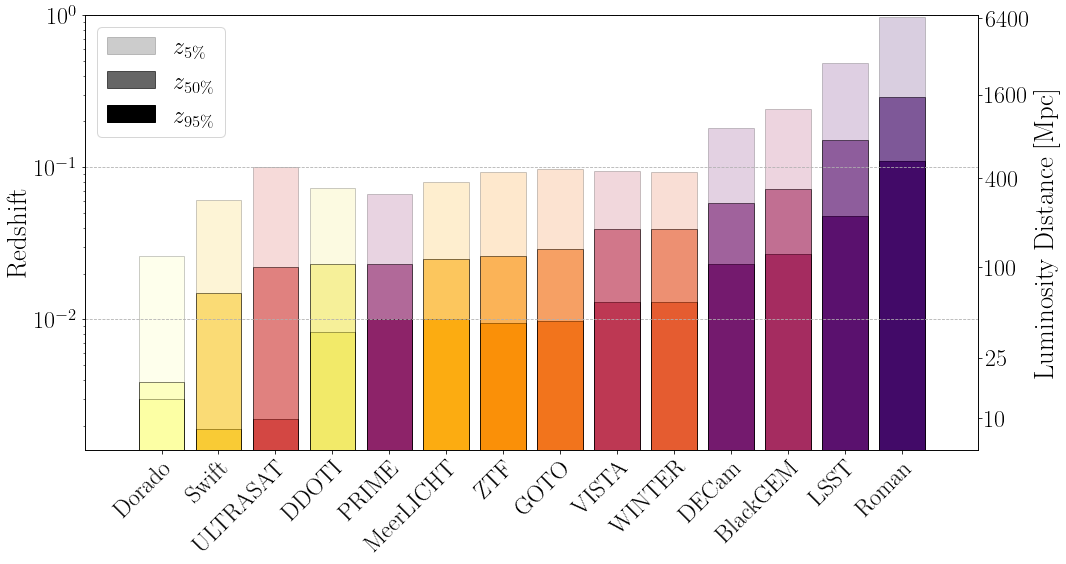

In [348]:
make_bar_chart(filter_data.sort_values(by=['z50'], ignore_index=True),
    fade=True, log=True, ymax=1)

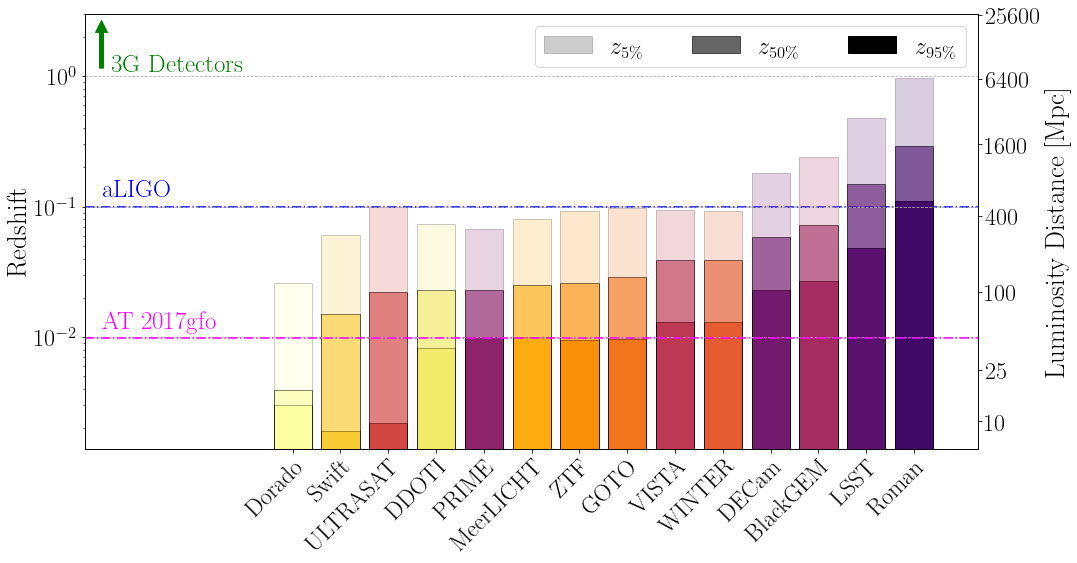

In [349]:
ax = make_bar_chart(filter_data.sort_values(by=['z50'], ignore_index=True),
    fade=True, log=True, ymax=3, gwranges='zhoriz',
    arrowbottom=1.1, arrowtop=2.8)
ax.legend(loc='upper right', ncol=3)

<AxesSubplot:ylabel='Redshift'>

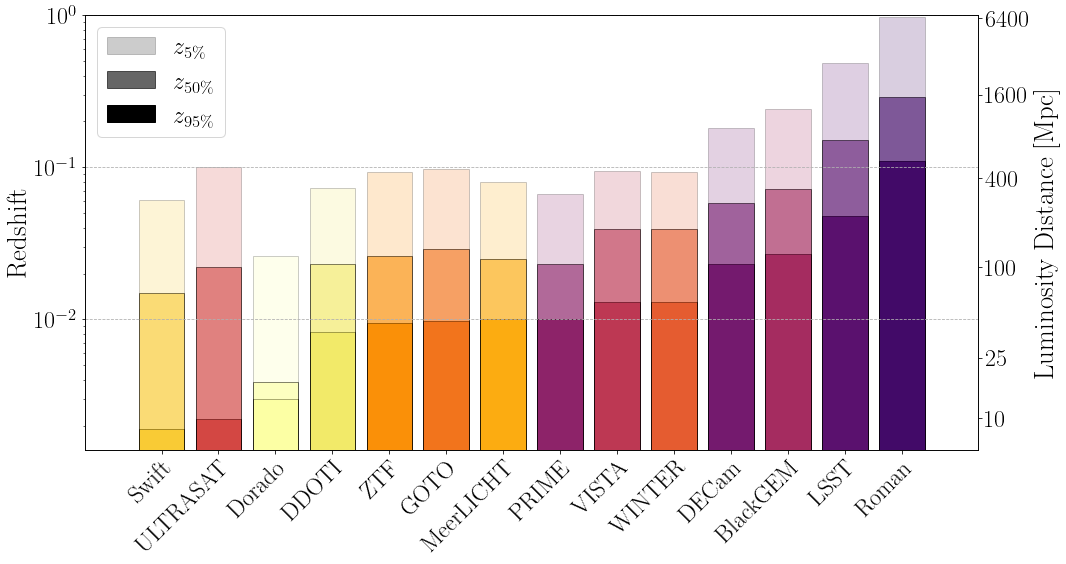

In [350]:
make_bar_chart(filter_data.sort_values(by=['z95'], ignore_index=True),
    fade=True, log=True, ymax=1)

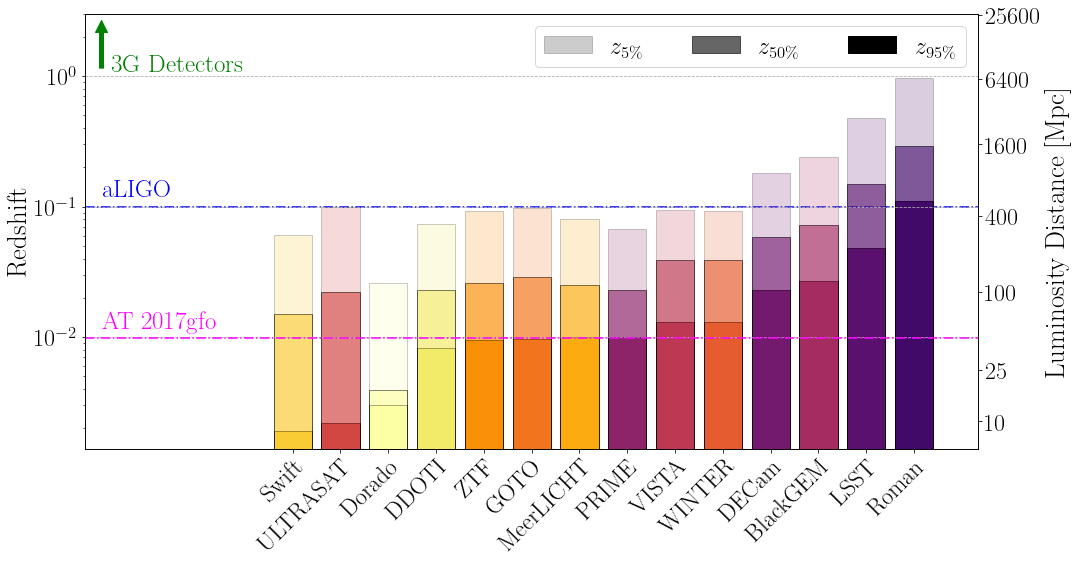

In [351]:
ax = make_bar_chart(filter_data.sort_values(by=['z95'], ignore_index=True),
    fade=True, log=True, ymax=3, gwranges='zhoriz',
    arrowbottom=1.1, arrowtop=2.8)
ax.legend(loc='upper right', ncol=3)